# 1. Generate Background Data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import matplotlib.patches as patches
import time as t
from scipy import optimize

n = 500
fr = 5 #fr: average firing rate of each input neuron (Hz)
duration = 1
np.random.seed(0)

def gen_background_data(n, fr, duration): 
    dt = 0.001 #bin (s)
    gen_bg = np.random.random((n, np.rint(duration/dt).astype(int)))<fr*dt
    gen_bg = gen_bg.astype(int)
    return gen_bg
print(gen_background_data(n, fr, duration))
print('Total firing of 500 neurons in 1 second: ' + str(np.sum(gen_background_data(n, fr, duration))))
#print(np.array(np.sum(gen_background_data(n, fr, duration),axis=1))) #sum of rows: total firing for each neuron
#print(np.array(np.sum(gen_background_data(n, fr, duration),axis=0))) #sum of columns: total firing in each bin (1ms)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
Total firing of 500 neurons in 1 second: 2447


## 1.1 Raster Plot for Background Activity

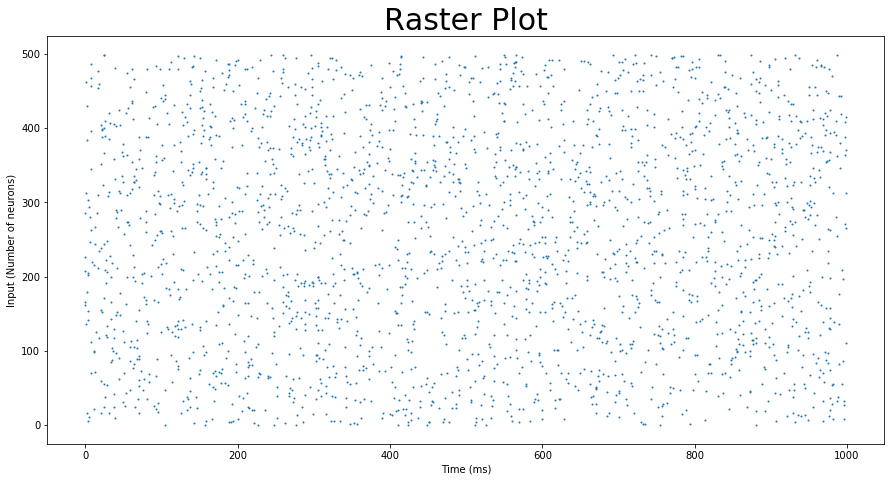

In [4]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)

spikes = gen_background_data(n, fr, duration)
y,x = np.argwhere(spikes == 1).T
plt.scatter(x, y, s=1)
plt.xlabel('Time (ms)')
plt.ylabel('Input (Number of neurons)')
plt.title('Raster Plot', fontsize=30)

# 2. Neuron Model

## 2.1 Kernel Plot

(0, 200)

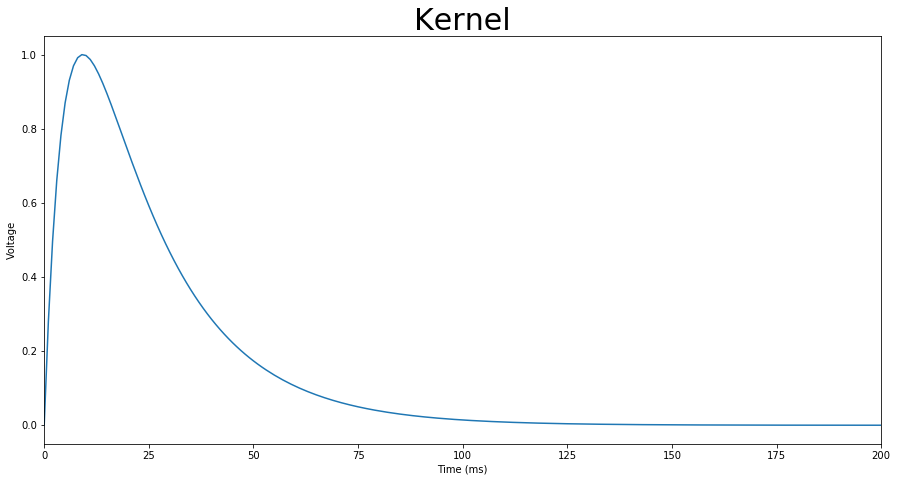

In [5]:
tau_mem = 20 #ms
tau_syn = 5 #ms
time_ij = 0 #ms
duration = 1
dt = 0.001
data = gen_background_data(n, fr, duration)

def kernel_fn(data, tau_mem, tau_syn, time_ij):
    time = np.arange(0., len(data[0]), 1.) #ms
    kernel = np.zeros(len(data[0]))
    eta = tau_mem/tau_syn
    V_norm = eta**(eta/(eta-1))/(eta-1)
    for count in range(len(data[0])):
        kernel[count] = V_norm*(np.exp(-(time[count]-time_ij)/tau_mem)-np.exp(-(time[count]-time_ij)/tau_syn))
    return kernel

time = np.arange(0., len(data[0]), 1.) #ms
kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Kernel", fontsize=30)
plt.plot(time, kernel)
plt.xlim((0,200))

## 2.2 Leaky Integrate-and-Fire Neuron Model with Reset

### 2.2.1 Exponential Function 

In [6]:
n = 500
fr = 5 #average firing rate of each input neuron (Hz)
duration = 1 #s
dt = 0.001 #bin (s)
data = gen_background_data(n, fr, duration)
V_rest = 0
theta = 1 #spike threshold
omega_coefficient = 0.022
time = np.arange(0, duration/dt+100, 1) #ms
time_ij = 0 #ms

def gen_omega(n, omega_coefficient):
    np.random.seed(100000)
    omega = np.random.random(n)*omega_coefficient
    return omega
random_omega = gen_omega(n, omega_coefficient)

### 2.2.2 Calculating Voltage 

In [7]:
def calculate_Vt(data, theta, omega):
    num_spikes = 0
    data = np.concatenate((data, np.zeros((n, 100))), axis=1)
    kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
    kernel_array = np.zeros((n,len(data[0])))
    V_t = np.zeros(len(data[0]))
    exp = np.exp(-np.arange(0, data.shape[1])/tau_mem)
    sum_time_exp = np.zeros(len(data[0]))
    spike_time = []
    #t5 = t.perf_counter()
    for neuron, ith_bin in zip(*np.where(data)):
        kernel_array[neuron, ith_bin:] += np.multiply(kernel, omega[neuron])[:len(kernel)-ith_bin]
    tot_input = kernel_array.sum(axis=0)
    for ith_bin in range(data.shape[1]):
        V_t[ith_bin] = V_rest + tot_input[ith_bin] - theta*sum_time_exp[ith_bin]  #calculate V(t)
        if V_t[ith_bin] >= theta:
            #V_t[ith_bin] = 1.5
            num_spikes += 1
            spike_time.append(ith_bin)
            sum_time_exp[ith_bin:] += exp[:len(data[0])-ith_bin]
    #print(t.perf_counter()-t5)
    return V_t, num_spikes, spike_time

V_t, num_spikes, spike_time = calculate_Vt(data, theta, random_omega)
print("number of spikes: " + str(num_spikes), V_t)
print(spike_time)

number of spikes: 4 [ 0.          0.01301908  0.02749125 ...,  0.01078177  0.01025594
  0.00975575]
[300, 538, 755, 926]


In [77]:
#for learning curve
omega = random_omega
data = gen_background_data(500, 5, 2)

def kernel_fn(tau_mem, tau_syn, time_ij):
    time = np.arange(0., 2100, 1.) #ms
    kernel = np.zeros(2100)
    eta = tau_mem/tau_syn
    V_norm = eta**(eta/(eta-1))/(eta-1)
    for count in range(2100):
        kernel[count] = V_norm*(np.exp(-(time[count]-time_ij)/tau_mem)-np.exp(-(time[count]-time_ij)/tau_syn))
    return kernel
kernel = kernel_fn(tau_mem, tau_syn, time_ij)

def calculate_Vt(data, theta, omega):
    num_spikes = 0
    data = np.concatenate((data, np.zeros((n, 100))), axis=1)
    kernel_array = np.zeros((n,len(data[0])))
    V_t = np.zeros(len(data[0]))
    exp = np.exp(-np.arange(0, data.shape[1])/tau_mem)
    sum_time_exp = np.zeros(len(data[0]))
    spike_time = []
    #t5 = t.perf_counter()
    for neuron, ith_bin in zip(*np.where(data)):
        kernel_array[neuron, ith_bin:] += np.multiply(kernel, omega[neuron])[:len(kernel)-ith_bin]
    tot_input = kernel_array.sum(axis=0)
    for ith_bin in range(data.shape[1]):
        V_t[ith_bin] = V_rest + tot_input[ith_bin] - theta*sum_time_exp[ith_bin]  #calculate V(t)
        if V_t[ith_bin] >= theta:
            #V_t[ith_bin] = 1.5
            num_spikes += 1
            spike_time.append(ith_bin)
            sum_time_exp[ith_bin:] += exp[:len(data[0])-ith_bin]
    #print(t.perf_counter()-t5)
    return V_t, num_spikes, spike_time

V_t, num_spikes, spike_time = calculate_Vt(data, theta, omega)
print("number of spikes: " + str(num_spikes), V_t)
print(spike_time)

number of spikes: 5 [ 0.          0.00710683  0.01731973 ...,  0.00872329  0.00829785
  0.00789316]
[372, 594, 1461, 1547, 1688]


### 2.2.3 Plotting LIF Neuron Model with Reset 

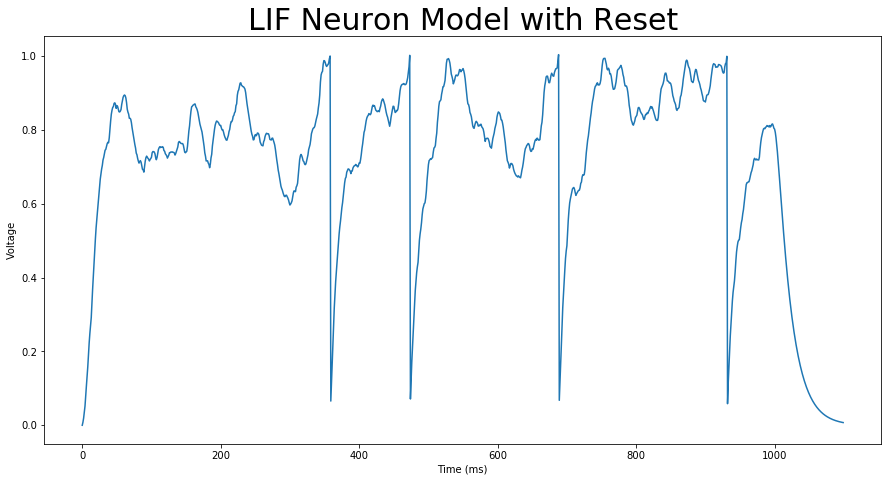

In [132]:
time = np.arange(0., len(data[0])+100, 1.) #ms

matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("LIF Neuron Model with Reset", fontsize=30)
plt.plot(time, V_t)

### 2.2.4 LIF Neuron Model (Reshape)

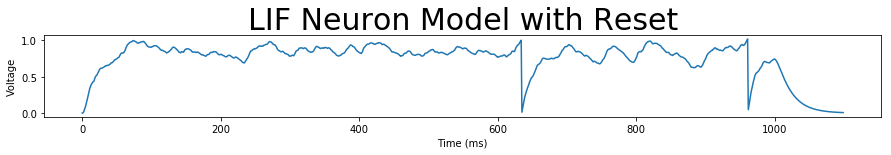

In [37]:
matplotlib.rcParams['figure.figsize'] = (15.0, 1.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("LIF Neuron Model with Reset", fontsize=30)
plt.plot(time, V_t)
#plt.xlim(0,1100)

# 3. Spike-Threshold-Surface (STS)

## 3.1 Calculate STS by Equally Spaced Thresholds (Theta)

In [86]:
def STS(theta):
    num_spikes = 0
    gen_omega = np.random.random(n)*omega_coefficient #generate different synaptic efficacies for different neurons
    kernel_array = np.zeros((n,np.rint(duration/dt).astype(int)+100))
    V_t = np.zeros(np.rint(duration/dt).astype(int)+100)
    sum_time_exp = np.zeros(np.rint(duration/dt).astype(int)+100)
    ith_bin = 0
    while ith_bin < np.rint(duration/dt).astype(int)+100:
        omega_i = np.multiply(data[:, ith_bin], gen_omega) #synaptic efficacy of ith input
        neuron = 0
        while neuron < n:
            if data[neuron, ith_bin] == 1:
                kernel_i = np.multiply(kernel, omega_i[neuron])
                fill = [0.]*ith_bin
                kernel_array[neuron] += np.append(fill, kernel_i[0:np.rint(duration/dt).astype(int)+100-ith_bin])
            neuron += 1
        sum_kernel_omega = np.sum(kernel_array[:, ith_bin])
        #calculate V(t)
        V_t[ith_bin] = V_rest + sum_kernel_omega - theta*sum_time_exp[ith_bin]
        if V_t[ith_bin] >= theta:
            V_t[ith_bin] = 1.5
            num_spikes += 1
            spike_fill = [0.]*(ith_bin+1) #reset at next bin
            sum_time_exp += np.append(spike_fill, time_exp[0:np.rint(duration/dt).astype(int)+100-ith_bin-1])
        ith_bin += 1
    return num_spikes

## 3.1.1 Plotting Spike-Threshold-Surface (Equally Spaced Theta)

In [9]:
def STS_data():
    theta = np.linspace(0.9, 1.1, 400) 
    count = 0
    num_spikes = []
    while count < len(theta):
        num_spikes.append(STS(theta[count]))
        count += 1
    return theta, num_spikes

theta, num_spikes = STS_data()

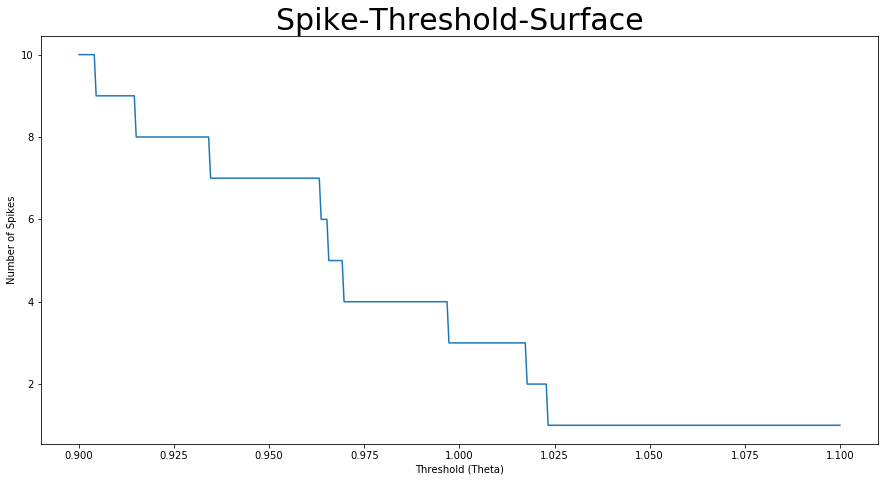

In [10]:
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Threshold (Theta)")
plt.ylabel("Number of Spikes")
plt.title("Spike-Threshold-Surface", fontsize=30)
plt.plot(theta, num_spikes)

## 3.2 Calculate STS by Bisection 

### 3.2.1 Bisection Function 

In [129]:
theta_range = [0.9, 1.1]
smallest_theta_range = 0.001 #actual interval = smallest_theta_range/2
low = 3
high = 4

def bisect(theta_range, low, high, smallest_theta_range):
    assert (high == low + 1)
    theta_list = [theta_range[0], sum(theta_range)/2, theta_range[1]]
    spike_list = [high, STS(data, sum(theta_range)/2, omega), low]
    if max(theta_range) - min(theta_range) >= smallest_theta_range:
        if STS(data, sum(theta_range)/2, omega) == low:
            theta_range = [theta_range[0], sum(theta_range)/2]
        else:
            theta_range = [sum(theta_range)/2, theta_range[1]]
        mid_theta, mid_spike = bisect(theta_range, low, high, smallest_theta_range)[0][1:-1], bisect(theta_range, low, high, smallest_theta_range)[1][1:-1]
        return sorted(np.append(theta_list, mid_theta)), sorted(np.append(spike_list, mid_spike), reverse=True)
    else:
        return theta_list, spike_list
print(bisect(theta_range, low, high, smallest_theta_range))


([0.90000000000000002, 1.0, 1.0125, 1.0187499999999998, 1.0203124999999997, 1.0210937499999999, 1.021484375, 1.0218749999999999, 1.0249999999999999, 1.05, 1.1000000000000001], [4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3])


### 3.2.2 STS Function

In [11]:
def STS_function(data, theta_range, omega_coefficient):
    spikes = []
    test_range = np.linspace(theta_range[0], theta_range[1], 15) #equal space of the range of threshold
    theta = test_range[0]
    count = 0
    while count < len(test_range):
        spikes.append(calculate_Vt(data, test_range[count], omega_coefficient)[1]) #calculate number of spikes for each point in test_range
        count += 1
    num_spikes = spikes[0]
    ind_spike = sorted(list(set(spikes)))[::-1] #remove duplicate in spikes
    assert (len(ind_spike) > 1), "All spike numbers are same, change your theta_range!"                
    count = 0
    while count < len(ind_spike)-1:
        #import pdb; pdb.set_trace()
        spike_index = spikes.index(ind_spike[count+1])
        theta_range = [test_range[spike_index-1], test_range[spike_index]]
        print(spikes[spike_index-1], spikes[spike_index])
        if spikes[spike_index-1] - spikes[spike_index] == 1:
            bisection = bisect(theta_range, spikes[spike_index], spikes[spike_index-1], smallest_theta_range)
            theta = np.append(theta, bisection[0])
            num_spikes = np.append(num_spikes, bisection[1])
        else:
            assert(spikes[spike_index-1] - spikes[spike_index] > 1)
            STS_fn = STS_function(data, theta_range, omega_coefficient)
            theta = np.append(theta, STS_fn[0])
            num_spikes = np.append(num_spikes, STS_fn[1])
        count += 1
    return theta, num_spikes

theta, num_spikes = STS_function(data, theta_range, omega_coefficient)

12 10
12 11
11 10
10 9
9 7
9 8
8 7
7 6
6 5
5 4
4 3
3 1
3 2
2 1
1 0


### 3.2.3 Theta Critical 

In [23]:
def theta_critical(theta, num_spikes):
    theta_critical = {}
    ind_spike = sorted(list(set(num_spikes)))[::-1] #remove duplicate in spikes
    count = 0
    while count < len(ind_spike)-1:
        spike_index = num_spikes.tolist().index(ind_spike[count+1])
        theta_critical[num_spikes[spike_index-1]] = theta[spike_index-1]
        count += 1
    return theta_critical

print(theta_critical(theta, num_spikes))

{12: 0.90994897959183674, 11: 0.91122448979591841, 10: 0.92366071428571428, 9: 0.9285714285714286, 8: 0.93673469387755104, 7: 0.95669642857142856, 6: 0.99464285714285716, 5: 1.003125, 4: 1.0245535714285714, 3: 1.031122448979592, 2: 1.0334183673469388, 1: 1.0910714285714287}


### 3.2.4 Plotting Spike-Threshold-Surface (Bisection)

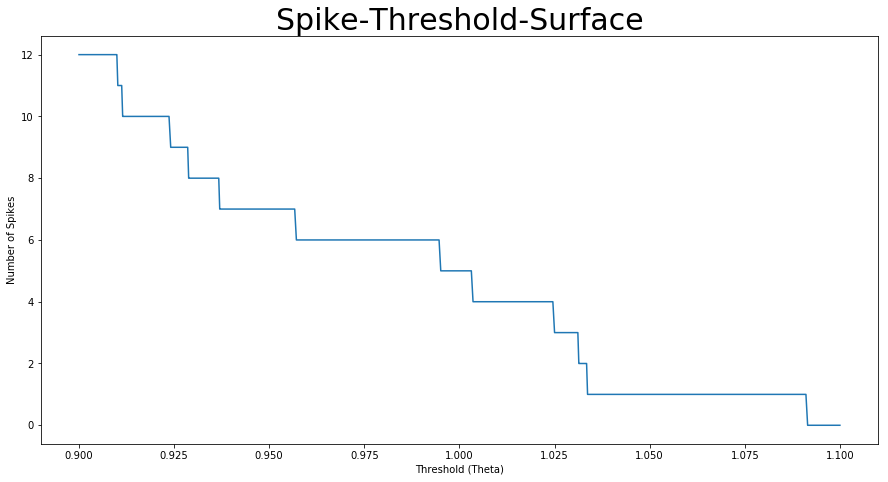

In [22]:
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Threshold (Theta)")
plt.ylabel("Number of Spikes")
plt.title("Spike-Threshold-Surface", fontsize=30)
plt.plot(theta, num_spikes)

# 4. Generating and Embedding Features

## 4.1 Generate and Reorder Features 

In [12]:
n = 500
#mean trial duration = T_null + n_fea*cf_mean*T_fea
n_fea = 5 #number of different features
cf_mean = 2 #mean for number of occurrences for each feature
fr = 5 #average firing rate of each input neuron (Hz)
T_null = 0.45 #background activity duration (s)
T_fea = 0.05 #T_fea: feature duration (s)
dt = 0.001 #bin (s)
n_fea_occur = np.random.poisson(cf_mean, n_fea) #number of occurrences for each feature
bg_data = gen_background_data(n, fr, T_null) #random background activity
time_occur = np.sort(np.round(np.random.random(np.sum(n_fea_occur))*T_null, 3)) #the occurrence time for each feature
sum(n_fea_occur)

7

In [13]:
def gen_features(n_fea, n, fr, T_fea): 
    a = 0
    features = {}
    while a < n_fea:
        features['feature_'+str(a)] = (np.random.random((n, np.rint(T_fea/dt).astype(int)))<fr*dt).astype(int)
        a += 1
    return features
features = gen_features(n_fea, n, fr, T_fea)

In [14]:
def order_occur(n_fea):
    count = 0
    order = []
    while count < n_fea:
        order += [count]*n_fea_occur[count]
        count += 1
    return np.random.permutation(order)
order_occur = order_occur(n_fea)

## 4.2 Embed Features into Background Activity 

In [15]:
def gen_input_data():
    index = np.rint(time_occur/dt).astype(int)
    feature_data = bg_data
    count = 0
    while count < len(index):
        feature_data = np.insert(feature_data, index[count], features['feature_'+str(order_occur[count])].T, axis = 1)
        index += np.rint(T_fea/dt).astype(int)
        count += 1
    return feature_data
input_data = gen_input_data()

#print(bg_data)
#print(n_fea_occur)
#print(order_occur)
#print(time_occur)
#print(gen_features(n_fea, n, fr, T_fea))
#print(embed_features)

## 4.3 Add Marker to Features

In [16]:
def add_marker(y_axis, height):
    index = time_occur/dt
    markers = []
    color = ['r','b','g','m', '#FF6600', '#00ffff', '#FDEE00', '#D71868', 'y', 'c', 'k']
    count = 0
    while count < len(index):
        index[count] += count*T_fea/dt
        markers.append(patches.Rectangle((index[count]-0.5, y_axis), T_fea/dt, height, fc = color[order_occur[count]], ec = '#000000'))
        count += 1
    return markers
markers = add_marker(n, n/40)


## 4.4 Plotting Data with Features Embedded 

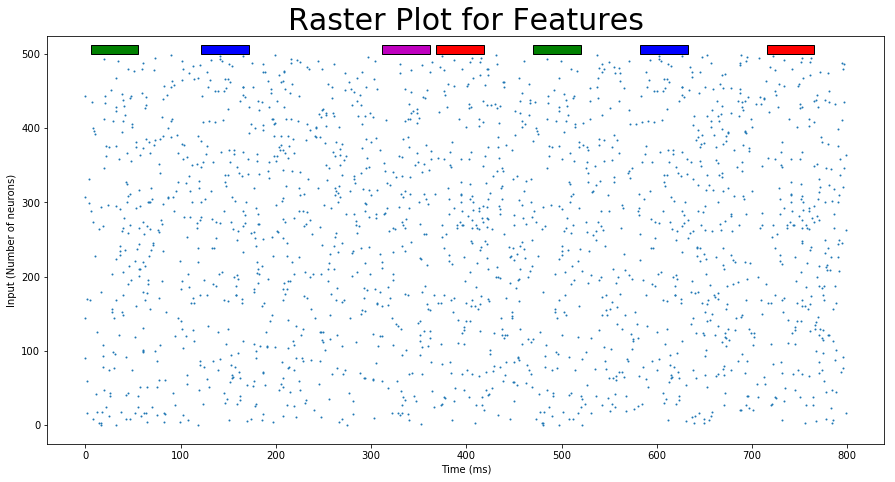

In [17]:
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
y,x = np.argwhere(input_data == 1).T
plt.scatter(x, y, s=1)
for marker in markers:
    plt.gca().add_patch(marker)
plt.xlabel('Time (ms)')
plt.ylabel('Input (Number of neurons)')
#plt.xlim(-1, 25)
#plt.ylim(-1,6)
plt.title('Raster Plot for Features', fontsize=30)

# 5. Training Procedures

## 5.1 Multi-Spike Tempotron 

### 5.1.1 Correlation-Based Learning 

In [18]:
data = input_data #Section 4.2
theta = 1
V_t, num_spikes, spike_time = calculate_Vt(data, theta, random_omega)

def eligibility(data, V_t):
    data = np.concatenate((data, np.zeros((n, 100))), axis=1)
    kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
    dic = dict.fromkeys(range(len(data)))
    neuron_eligibility = {value: 0 for value in dic} #To store the eligibility of each neuron
    neuron = 0 #index of input neurons
    for i, j in zip(*np.where(data)):
        eligibility = 0
        eligibility += np.sum(np.multiply(V_t, np.append(np.zeros(j), kernel[:len(kernel)-j]))*dt) #eligibility += individual correlation
        neuron_eligibility[i] += eligibility
    return neuron_eligibility

elig = eligibility(data, V_t)
print(elig)
print(elig[max(elig, key=elig.get)])
print(max(elig, key=elig.get))
print(num_spikes, spike_time)


{0: 0.064861195704391486, 1: 0.093218222815327795, 2: 0.023994419189430488, 3: 0.18302829216826452, 4: 0.073343754846399462, 5: 0.047890363320605492, 6: 0.06981326369498847, 7: 0.20765274072799525, 8: 0.12112169850037148, 9: 0.12642358445532648, 10: 0.023557696414612337, 11: 0.068002006938591125, 12: 0.090445067719288411, 13: 0.042239083977971943, 14: 0.1002903858161722, 15: 0.097366687163187915, 16: 0.10925668741633783, 17: 0.15787807337557605, 18: 0.1478781338307206, 19: 0.051517241064426469, 20: 0.07520956311280777, 21: 0.055543642634813303, 22: 0.02420413515346706, 23: 0.037365829486274066, 24: 0.026459002516745916, 25: 0.14334837345441015, 26: 0.070690888752227204, 27: 0.28940223907141105, 28: 0.12703071567923976, 29: 0.10017685148435758, 30: 0.07435559965665231, 31: 0, 32: 0.051309977799104109, 33: 0.072324072448182369, 34: 0.099021392504160075, 35: 0.05014370140934242, 36: 0.052607082229105179, 37: 0.074231832843811879, 38: 0.19271399282879936, 39: 0.076510030400779666, 40: 0.19

In [19]:
desired_spikes = 6
learning_rate = 0.0001 #lambda
elig = eligibility(data, V_t)
init_omega = random_omega

def synaptic_update(elig, init_omega, learning_rate, num_spikes, desired_spikes):
    D9 = sorted(elig, key=elig.get, reverse=True)[int(n/10)] #9th decile
    updated_omega = []
    count = 0
    while count < len(elig):
        if num_spikes < desired_spikes:
            if elig[count] > elig[D9]:
                updated_omega = np.append(updated_omega, init_omega[count] + learning_rate)
            else:
                updated_omega = np.append(updated_omega, init_omega[count])
        elif num_spikes > desired_spikes:
            if elig[count] > elig[D9]:
                updated_omega = np.append(updated_omega, init_omega[count] - learning_rate)
            else:
                updated_omega = np.append(updated_omega, init_omega[count])
        else:
            return init_omega
        count += 1
    return updated_omega

updated_omega = synaptic_update(elig, init_omega, learning_rate, 5, desired_spikes)
print(updated_omega)

[ 0.00632634  0.01118146  0.0109569   0.01729673  0.00269288  0.00637686
  0.00059806  0.01257372  0.01030492  0.01076243  0.02005798  0.0141056
  0.00884884  0.00191827  0.01553017  0.00958147  0.00486814  0.01780977
  0.0141986   0.00986601  0.02155152  0.00489477  0.00934874  0.00819512
  0.02043831  0.00390615  0.01913454  0.01776873  0.00684041  0.00545152
  0.02008044  0.01954119  0.00417931  0.01873329  0.00668799  0.00926748
  0.0052398   0.00177345  0.00670888  0.01891351  0.02050447  0.01654198
  0.01920403  0.00134303  0.01120238  0.01269426  0.01696935  0.01403419
  0.00901605  0.01753391  0.00332718  0.02092846  0.00740127  0.0165128
  0.01967078  0.02109599  0.00256277  0.01600984  0.00762088  0.00030436
  0.0077937   0.00202798  0.01032811  0.02174133  0.01725175  0.0014397
  0.00073005  0.00288695  0.01283911  0.00607779  0.00131882  0.00933806
  0.01818263  0.00158297  0.01679163  0.01496407  0.0183975   0.00329163
  0.02014303  0.02050255  0.01902006  0.01130277  0.00

In [18]:
desired_spikes = 6
learning_rate = 0.0001 #lambda
elig = eligibility(data, V_t)
init_omega = np.copy(random_omega)

def synaptic_update(elig, init_omega, learning_rate, num_spikes, desired_spikes):
    D9 = sorted(elig, key=elig.get, reverse=True)[int(n/10)] #9th decile
    elig_values = np.asarray(list(elig.values()))
    if num_spikes < desired_spikes:
        init_omega[elig_values>elig[D9]] += learning_rate
    elif num_spikes > desired_spikes:
        init_omega[elig_values>elig[D9]] -= learning_rate
    else:
        return init_omega
    return init_omega

updated_omega = synaptic_update(elig, init_omega, learning_rate, 5, desired_spikes)
print(updated_omega)

[ 0.00632634  0.01118146  0.0109569   0.01729673  0.00269288  0.00637686
  0.00059806  0.01257372  0.01030492  0.01076243  0.02005798  0.0141056
  0.00884884  0.00191827  0.01553017  0.00958147  0.00486814  0.01780977
  0.0141986   0.00986601  0.02155152  0.00489477  0.00934874  0.00819512
  0.02043831  0.00390615  0.01913454  0.01776873  0.00684041  0.00545152
  0.02008044  0.01954119  0.00417931  0.01873329  0.00668799  0.00926748
  0.0052398   0.00177345  0.00670888  0.01891351  0.02050447  0.01654198
  0.01920403  0.00134303  0.01120238  0.01269426  0.01696935  0.01403419
  0.00901605  0.01753391  0.00332718  0.02092846  0.00740127  0.0165128
  0.01967078  0.02109599  0.00256277  0.01600984  0.00762088  0.00030436
  0.0077937   0.00202798  0.01032811  0.02174133  0.01725175  0.0014397
  0.00073005  0.00288695  0.01283911  0.00607779  0.00131882  0.00933806
  0.01818263  0.00158297  0.01679163  0.01496407  0.0183975   0.00329163
  0.02014303  0.02050255  0.01902006  0.01130277  0.00

(0, 1.2)

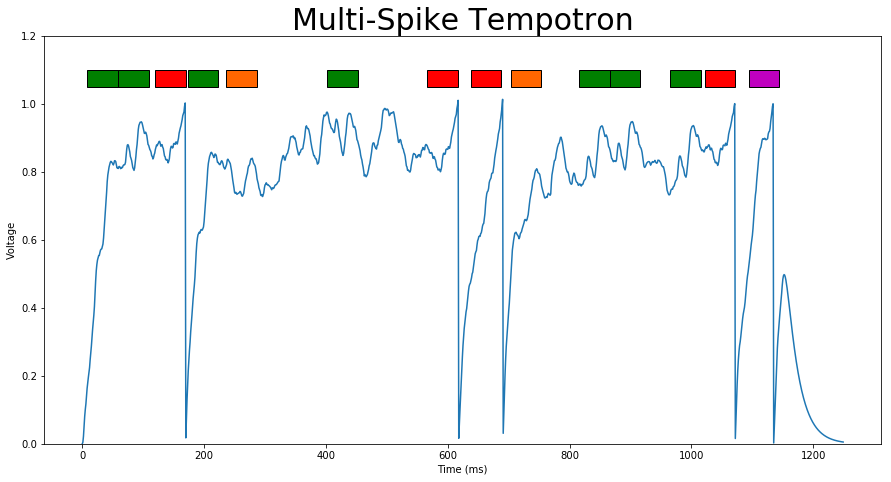

In [26]:
data = input_data #Section 4.2
omega_coefficient = 0.022
theta = 1
time = np.arange(0, len(data[0])+100, 1)
V_t, num_spikes, spike_time = calculate_Vt(data, theta, random_omega) 

matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Multi-Spike Tempotron", fontsize=30)
plt.plot(time, V_t)
for marker in add_marker(1.05, 0.05):
    plt.gca().add_patch(marker)
plt.ylim((0, 1.2))

# Training

In [9]:
from main_gen import gen_input_data
seed = 250
#duration = 1.5
n = 500
#mean trial duration = T_null + n_fea*cf_mean*T_fea
n_fea = 10 #number of different features
cf_mean = 2 #mean for number of occurrences for each feature
fr = 5 #average firing rate of each input neuron (Hz)
T_null = 0.5 #background activity duration (s)
T_fea = 0.05 #T_fea: feature duration (s)
dt = 0.001 #bin (s)
marker_y = 1.05
marker_height = 0.05
#n_fea_occur = np.random.poisson(cf_mean, n_fea) #number of occurrences for each feature
#bg_data = gen_background_data(n, fr, T_null) #random background activity
#time_occur = np.sort(np.round(np.random.random(np.sum(n_fea_occur))*T_null, 3)) #the occurrence time for each feature

input_data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)
print(fea_time)
print(fea_order)
print(features)

[13, 70, 130, 192, 285, 395, 467, 539, 593, 661, 724, 795, 880, 939, 1024, 1083, 1191, 1259, 1318, 1375, 1436, 1489, 1549, 1631]
[5 9 9 0 8 6 7 5 4 6 2 1 4 3 6 1 2 9 8 7 1 2 5 7]
{'feature_0': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'feature_1': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'feature_2': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'feature_3': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
      

1


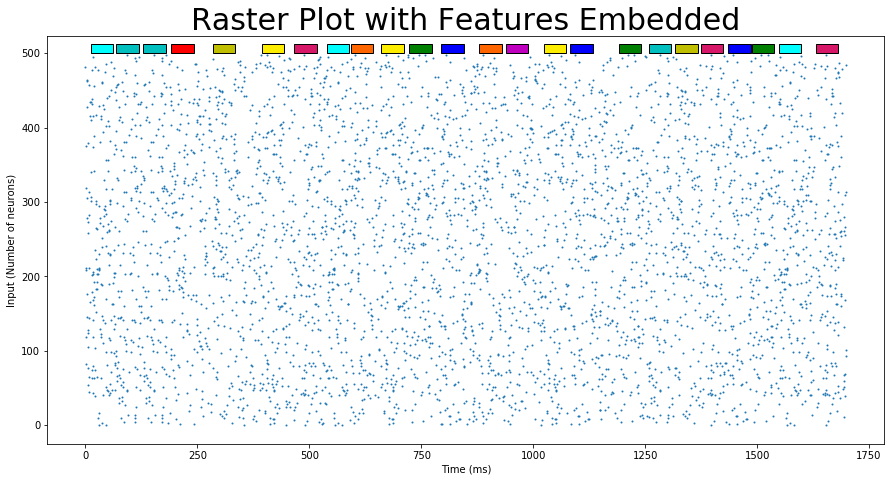

In [30]:
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
y,x = np.argwhere(input_data == 1).T
plt.scatter(x, y, s=1)
for marker in markers:
    plt.gca().add_patch(marker)
plt.xlabel('Time (ms)')
plt.ylabel('Input (Number of neurons)')
#plt.xlim(-1, 25)
#plt.ylim(-1,6)
plt.title('Raster Plot with Features Embedded', fontsize=30)
print(n_fea_occur[0])

3 [408, 751, 917]


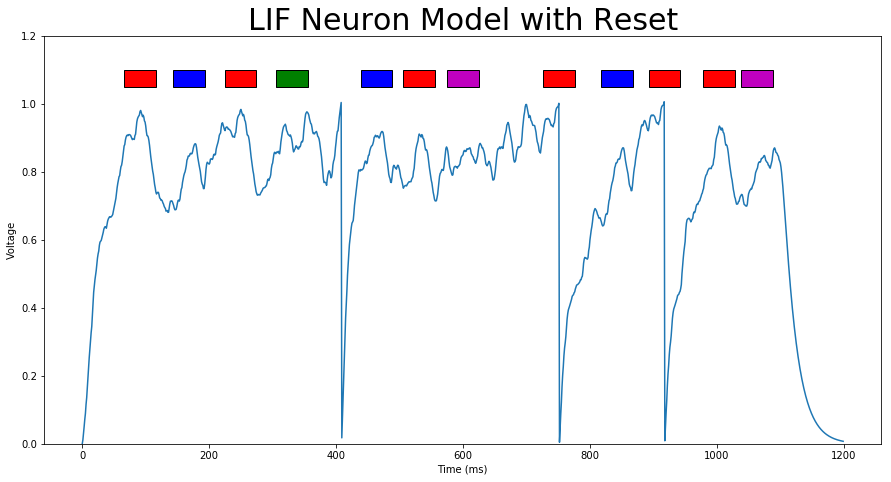

In [16]:
data = input_data
theta = 1
time = np.arange(0., len(data[0])+100, 1.) #ms

V_t, num_spikes, spike_time = calculate_Vt(data, theta, random_omega)

matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("LIF Neuron Model with Reset", fontsize=30)
plt.plot(time, V_t)
for marker in markers:
    plt.gca().add_patch(marker)
plt.ylim((0, 1.2))
print(num_spikes, spike_time)

In [265]:
#elig = eligibility(data, V_t)
#desired_spikes = 5
#learning_rate = 0.01 #lambda
#updated_omega = synaptic_update(elig, random_omega, learning_rate, desired_spikes)
#V_t, num_spikes = calculate_Vt(data, theta, omega_coefficient, random_omega)
omega = np.copy(random_omega)

def correlation_training(current_omega, n_cycles, fea_idx, learning_rate):
    t1 = t.perf_counter()
    cycle = 0
    seed = 0
    while cycle < n_cycles:     
        trial = cycle*100
        while seed < trial+100:
            data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)  
            desired_spikes = n_fea_occur[fea_idx]
            V_t, num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
            print('1', num_spikes, desired_spikes)
            if num_spikes != desired_spikes:
                new_num_spikes = num_spikes
                while new_num_spikes == num_spikes:
                    elig = eligibility(data, V_t)
                    V_t, new_num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
                    current_omega = synaptic_update(elig, current_omega, learning_rate, num_spikes, desired_spikes)
                    print('2', new_num_spikes, desired_spikes)
            seed += 1
            print('s: '+str(seed))
        cycle += 1
        print('c: '+str(cycle))
    t2 = t.perf_counter()
    return current_omega, V_t, num_spikes, t2-t1
current_omega, V_t, num_spikes, time = correlation_training(omega, 2, 0, 0.0001)
print(time)


1 3 3
s: 1
1 1 2
2 1 2
2 1 2
2 1 2
2 1 2
2 2 2
s: 2
1 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 3 1
s: 3
1 2 2
s: 4
1 0 5
2 0 5
2 0 5
2 0 5
2 0 5
2 0 5
2 0 5
2 0 5
2 1 5
s: 5
1 5 2
2 5 2
2 5 2
2 5 2
2 5 2
2 5 2
2 5 2
2 5 2
2 5 2
2 5 2
2 5 2
2 4 2
s: 6
1 0 3
2 0 3
2 0 3
2 0 3
2 0 3
2 0 3
2 0 3
2 0 3
2 0 3
2 0 3
2 1 3
s: 7
1 4 0
2 4 0
2 4 0
2 4 0
2 3 0
s: 8
1 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 1 4
2 2 4
s: 9
1 4 0
2 4 0
2 4 0
2 4 0
2 4 0
2 4 0
2 4 0
2 4 0
2 4 0
2 4 0
2 4 0
2 3 0
s: 10
1 3 1
2 3 1
2 3 1
2 3 1
2 2 1
s: 11
1 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 5 1
2 4 1
s: 12
1 1 1
s: 13
1 2 5
2 2 5
2 2 5
2 3 5
s: 14
1 2 3
2 2 3
2 2 3
2 2 3
2 2 3
2 2 3
2 2 3
2 3 3
s: 15
1 4 2
2 4 2
2 4 2
2 4 2
2 4 2
2 4 2
2 4 2
2 4 2
2 4 2
2 4 2
2 4 2
2 4 2
2 3 2
s: 16
1 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2 2 1
2

In [266]:
(current_omega-random_omega)*100

array([ 0.  ,  0.  ,  0.06, -0.02,  0.  , -0.04, -1.56,  0.  ,  0.33,
        0.28,  0.  ,  0.  , -0.47, -0.33,  0.  ,  0.  , -0.09,  0.23,
       -0.94, -0.09, -0.63,  0.  , -1.64,  0.61, -0.08, -0.35,  0.  ,
        0.2 , -0.33, -0.22, -0.05, -0.05, -0.08,  0.01,  0.15, -0.07,
       -0.21,  0.  , -0.39,  0.  , -0.76,  0.  , -0.11,  0.4 ,  0.3 ,
        0.13, -0.24, -0.01,  0.  , -0.59,  0.  ,  0.18, -1.06,  0.  ,
       -0.06, -1.34, -0.42, -0.34, -0.76,  0.  , -0.23, -0.11,  0.  ,
        0.31,  0.  , -0.54,  0.  ,  0.71, -0.05,  0.5 ,  0.75,  0.  ,
       -2.06,  0.  ,  1.21, -0.11, -0.23, -0.02, -0.3 , -0.15, -1.65,
        0.97,  0.  , -0.09, -0.05,  0.  , -0.13,  0.23, -0.34, -0.09,
        0.09, -0.13, -0.5 ,  0.01,  1.56,  0.89, -0.38,  0.  ,  0.  ,
       -1.67, -0.05, -1.55, -1.38,  0.  , -0.5 , -0.32, -0.24, -0.32,
       -0.2 , -0.03,  0.  , -0.01,  0.  , -0.05,  0.05,  0.12, -0.58,
       -0.18,  0.52, -0.41, -0.34,  0.  ,  0.  , -0.57, -0.65, -0.19,
        0.49, -0.11,

# 2

In [42]:
#elig = eligibility(data, V_t)
#desired_spikes = 5
#learning_rate = 0.01 #lambda
#updated_omega = synaptic_update(elig, random_omega, learning_rate, desired_spikes)
#V_t, num_spikes = calculate_Vt(data, theta, omega_coefficient, random_omega)
omega = np.copy(random_omega)

def correlation_training(current_omega, n_trials, fea_idx, learning_rate):
    seed = 0
    t1 = t.perf_counter()
    while seed < n_trials:
        data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)  
        desired_spikes = n_fea_occur[fea_idx]
        V_t, num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
        print('1', num_spikes, desired_spikes)
        if num_spikes != desired_spikes:
            new_num_spikes = num_spikes
            while new_num_spikes == num_spikes:
                elig = eligibility(data, V_t)
                V_t, new_num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
                current_omega = synaptic_update(elig, current_omega, learning_rate, num_spikes, desired_spikes)
                print('2', new_num_spikes, desired_spikes)
        seed += 1
        print(seed)
    t2 = t.perf_counter()
    return current_omega, V_t, num_spikes, t2-t1
current_omega, V_t, num_spikes, time = correlation_training(omega, 200, 0, 0.0001)
print(time)

1 3 3
1
1 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 2 2
2
1 3 1
2 3 1
2 3 1
2 3 1
2 3 1
2 3 1
2 3 1
2 3 1
2 3 1
2 3 1
2 3 1
2 3 1
2 2 1
3
1 1 2
2 1 2
2 1 2
2 1 2
2 1 2
2 1 2
2 1 2
2 1 2
2 1 2
2 1 2
2 1 2
2 2 2
4
1 0 5
2 0 5
2 0 5
2 0 5
2 0 5
2 0 5
2 0 5
2 0 5
2 0 5
2 1 5
5
1 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 3 2
2 2 2
6
1 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 1 3
2 2 3
7
1 3 0
2 3 0
2 3 0
2 2 0
8
1 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 2 4
2 4 4
9
1 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 2 0
2 1 0
10
1 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 3 1
11
1 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 4 1
2 3 1
12
1 1 1
1

In [320]:
(current_omega - random_omega)*100

array([ 0.  ,  0.  ,  0.06, -0.02,  0.  , -0.04, -1.56,  0.  ,  0.33,
        0.28,  0.  ,  0.  , -0.47, -0.33,  0.  ,  0.  , -0.09,  0.23,
       -0.94, -0.09, -0.63,  0.  , -1.64,  0.61, -0.08, -0.35,  0.  ,
        0.2 , -0.33, -0.22, -0.05, -0.05, -0.08,  0.01,  0.15, -0.07,
       -0.21,  0.  , -0.39,  0.  , -0.76,  0.  , -0.11,  0.4 ,  0.3 ,
        0.13, -0.24, -0.01,  0.  , -0.59,  0.  ,  0.18, -1.06,  0.  ,
       -0.06, -1.34, -0.42, -0.34, -0.76,  0.  , -0.23, -0.11,  0.  ,
        0.31,  0.  , -0.54,  0.  ,  0.71, -0.05,  0.5 ,  0.75,  0.  ,
       -2.06,  0.  ,  1.21, -0.11, -0.23, -0.02, -0.3 , -0.15, -1.65,
        0.97,  0.  , -0.09, -0.05,  0.  , -0.13,  0.23, -0.34, -0.09,
        0.09, -0.13, -0.5 ,  0.01,  1.56,  0.89, -0.38,  0.  ,  0.  ,
       -1.67, -0.05, -1.55, -1.38,  0.  , -0.5 , -0.32, -0.24, -0.32,
       -0.2 , -0.03,  0.  , -0.01,  0.  , -0.05,  0.05,  0.12, -0.58,
       -0.18,  0.52, -0.41, -0.34,  0.  ,  0.  , -0.57, -0.65, -0.19,
        0.49, -0.11,

7


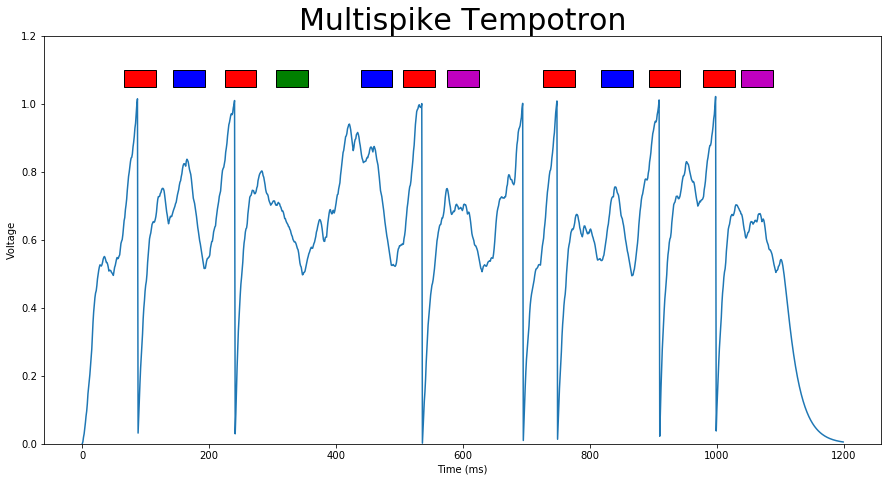

In [44]:
V_t, num_spikes, spike_time = calculate_Vt(input_data, theta, current_omega)
time = np.arange(0., len(data[0])+100, 1.) #ms
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Multispike Tempotron", fontsize=30)
plt.plot(time, V_t)
for marker in markers:
    plt.gca().add_patch(marker)
plt.ylim((0, 1.2))
print(num_spikes)

# 3 random select one set and update, remove those that have same spikes, end training when 10 consecutive trials have same spikes

In [307]:
#elig = eligibility(data, V_t)
#desired_spikes = 5
#learning_rate = 0.01 #lambda
#updated_omega = synaptic_update(elig, random_omega, learning_rate, desired_spikes)
#V_t, num_spikes = calculate_Vt(data, theta, omega_coefficient, random_omega)
omega = np.copy(random_omega)

def correlation_training(current_omega, n_trials, fea_idx, learning_rate):
    t1 = t.perf_counter()
    for i in range(6):
        seed = 0
        while seed < n_trials:
            data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)  
            desired_spikes = n_fea_occur[fea_idx]
            V_t, num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
            print('1', num_spikes, desired_spikes)
            if num_spikes != desired_spikes:
                elig = eligibility(data, V_t)
                V_t, new_num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
                current_omega = synaptic_update(elig, current_omega, learning_rate, num_spikes, desired_spikes)
                print('2', new_num_spikes, desired_spikes)
            seed += 1
            print(seed)
    t2 = t.perf_counter()
    return current_omega, V_t, num_spikes, t2-t1
current_omega, V_t, num_spikes, time = correlation_training(omega, 200, 0, 0.0001)
print(time)

1 3 3
1
1 1 2
2 1 2
2
1 4 1
2 4 1
3
1 3 2
2 3 2
4
1 0 5
2 0 5
5
1 5 2
2 5 2
6
1 0 3
2 0 3
7
1 4 0
2 4 0
8
1 0 4
2 0 4
9
1 4 0
2 4 0
10
1 3 1
2 3 1
11
1 5 1
2 5 1
12
1 3 1
2 3 1
13
1 5 5
14
1 3 3
15
1 5 2
2 5 2
16
1 4 1
2 4 1
17
1 0 2
2 0 2
18
1 5 3
2 5 3
19
1 1 0
2 1 0
20
1 4 4
21
1 4 0
2 4 0
22
1 3 1
2 3 1
23
1 3 3
24
1 4 4
25
1 1 3
2 1 3
26
1 2 2
27
1 3 4
2 3 4
28
1 4 2
2 4 2
29
1 3 2
2 3 2
30
1 1 3
2 1 3
31
1 3 4
2 3 4
32
1 3 4
2 3 4
33
1 1 1
34
1 3 0
2 3 0
35
1 3 2
2 3 2
36
1 2 3
2 2 3
37
1 3 2
2 3 2
38
1 2 5
2 2 5
39
1 3 3
40
1 3 1
2 3 1
41
1 2 1
2 2 1
42
1 1 4
2 1 4
43
1 4 0
2 4 0
44
1 1 1
45
1 3 3
46
1 3 2
2 3 2
47
1 6 0
2 6 0
48
1 2 0
2 2 0
49
1 4 1
2 4 1
50
1 0 1
2 0 1
51
1 0 1
2 0 1
52
1 0 1
2 0 1
53
1 3 3
54
1 1 2
2 1 2
55
1 2 0
2 2 0
56
1 4 3
2 4 3
57
1 1 0
2 1 0
58
1 3 2
2 3 2
59
1 2 2
60
1 1 1
61
1 3 2
2 3 2
62
1 1 0
2 1 0
63
1 0 2
2 0 2
64
1 3 2
2 3 2
65
1 2 1
2 2 1
66
1 2 1
2 2 1
67
1 0 3
2 0 3
68
1 1 1
69
1 3 2
2 3 2
70
1 2 5
2 2 5
71
1 4 1
2 4 1
72
1 5 0
2 5 0
73
1 1 

In [309]:
(current_omega - random_omega)*100

array([ 0.  ,  0.  ,  0.1 , -0.12, -0.05, -0.18, -0.76,  0.  , -0.01,
       -0.44,  0.06,  0.  , -0.68, -0.06, -0.11, -0.02, -0.07, -0.2 ,
       -0.54, -0.1 , -0.44, -0.1 , -0.22, -0.06, -0.03, -0.26, -0.01,
        0.16, -0.03, -0.02, -0.06, -0.05, -0.07, -0.1 ,  0.13, -0.06,
       -0.13,  0.  , -0.06,  0.  , -0.27, -0.04, -0.12,  0.2 ,  0.05,
       -0.3 , -0.08,  0.  ,  0.  , -0.54,  0.  ,  0.42, -0.44, -0.07,
       -0.8 , -0.51, -0.61, -0.07, -0.23,  0.  , -0.06, -0.06,  0.  ,
        0.21,  0.  , -0.21,  0.  ,  0.71, -0.29, -0.32, -0.12, -0.22,
       -0.37,  0.  ,  0.45,  0.  , -0.12, -0.05, -0.05, -0.14, -0.59,
        0.77, -0.01, -0.1 , -0.11,  0.  , -0.06,  0.02, -0.42, -0.15,
       -0.07, -0.19, -0.07, -0.03,  0.67,  0.06, -0.18,  0.  ,  0.  ,
       -0.32, -0.05, -0.21, -0.28,  0.  , -0.15, -0.07, -0.05, -0.03,
       -0.16,  0.  , -0.11, -0.01, -0.04, -0.05, -0.03, -0.51, -0.4 ,
       -0.28,  0.01, -0.09, -0.09,  0.  , -0.03,  0.07, -0.12, -0.19,
        0.12, -0.06,

# 4 Five spikes per feature / learning curve

In [47]:
#elig = eligibility(data, V_t)
#desired_spikes = 5
#learning_rate = 0.01 #lambda
#updated_omega = synaptic_update(elig, random_omega, learning_rate, desired_spikes)
#V_t, num_spikes = calculate_Vt(data, theta, omega_coefficient, random_omega)
omega = np.copy(random_omega)

def correlation_training(current_omega, n_cycles, fea_idx, learning_rate):
    t1 = t.perf_counter()
    cycle = 0
    seed = 0
    cur_omega_list = []
    while cycle < n_cycles:     
        trial = cycle*100
        while seed < trial+100:
            data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)  
            desired_spikes = n_fea_occur[fea_idx]*5
            V_t, num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
            #print('1', num_spikes, desired_spikes)
            if num_spikes != desired_spikes:
                elig = eligibility(data, V_t)
                #V_t, new_num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
                current_omega = synaptic_update(elig, current_omega, learning_rate, num_spikes, desired_spikes)
                #print('2', new_num_spikes, desired_spikes)
            seed += 1
            #print('s: '+str(seed))
        cur_omega_list.append(current_omega)
        cycle += 1
        print('c: '+str(cycle)) #+'; current_omega = '+str(current_omega))
    t2 = t.perf_counter()
    return cur_omega_list, t2-t1
cur_omega5_list, time = correlation_training(omega, 100, 0, 0.0001)
print(time)

c: 1
c: 2
c: 3
c: 4
c: 5
c: 6
c: 7
c: 8
c: 9
c: 10
c: 11
c: 12
c: 13
c: 14
c: 15
c: 16
c: 17
c: 18
c: 19
c: 20
c: 21
c: 22
c: 23
c: 24
c: 25
c: 26
c: 27
c: 28
c: 29
c: 30
c: 31
c: 32
c: 33
c: 34
c: 35
c: 36
c: 37
c: 38
c: 39
c: 40
c: 41
c: 42
c: 43
c: 44
c: 45
c: 46
c: 47
c: 48
c: 49
c: 50
c: 51
c: 52
c: 53
c: 54
c: 55
c: 56
c: 57
c: 58
c: 59
c: 60
c: 61
c: 62
c: 63
c: 64
c: 65
c: 66
c: 67
c: 68
c: 69
c: 70
c: 71
c: 72
c: 73
c: 74
c: 75
c: 76
c: 77
c: 78
c: 79
c: 80
c: 81
c: 82
c: 83
c: 84
c: 85
c: 86
c: 87
c: 88
c: 89
c: 90
c: 91
c: 92
c: 93
c: 94
c: 95
c: 96
c: 97
c: 98
c: 99
c: 100
1275.1172612870578


30


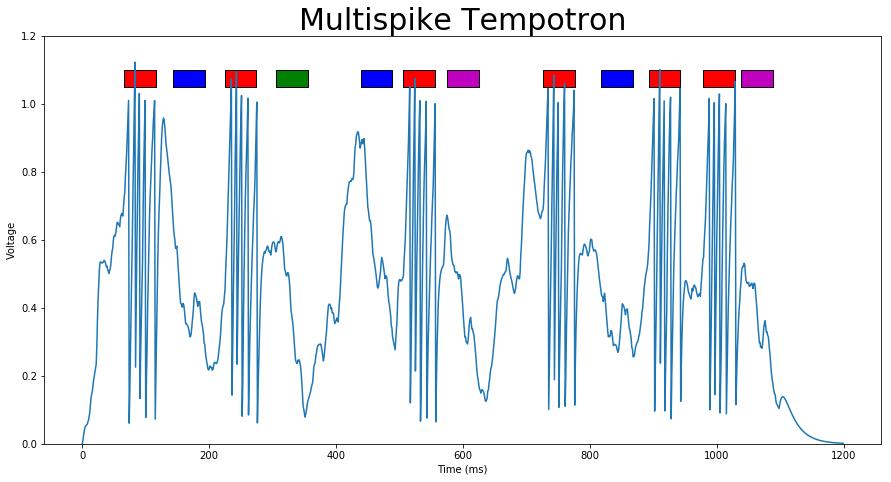

In [51]:
V_t, num_spikes, spike_time = calculate_Vt(input_data, theta, cur_omega5_list[99])
time = np.arange(0., len(input_data[0])+100, 1.) #ms
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Multispike Tempotron", fontsize=30)
plt.plot(time, V_t)
for marker in markers:
    plt.gca().add_patch(marker)
plt.ylim((0, 1.2))
print(num_spikes)

# 4.1 Multi features / learning curve

In [56]:
#elig = eligibility(data, V_t)
#desired_spikes = 5
#learning_rate = 0.01 #lambda
#updated_omega = synaptic_update(elig, random_omega, learning_rate, desired_spikes)
#V_t, num_spikes = calculate_Vt(data, theta, omega_coefficient, random_omega)
omega = np.copy(random_omega)

def correlation_training(current_omega, n_cycles, fea_idx, learning_rate):
    t1 = t.perf_counter()
    cycle = 0
    seed = 0
    cur_omega_list = []
    while cycle < n_cycles:     
        trial = cycle*100
        while seed < trial+100:
            data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)  
            desired_spikes = n_fea_occur[fea_idx] + n_fea_occur[fea_idx+1]
            V_t, num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
            #print('1', num_spikes, desired_spikes)
            if num_spikes != desired_spikes:
                elig = eligibility(data, V_t)
                #V_t, new_num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
                current_omega = synaptic_update(elig, current_omega, learning_rate, num_spikes, desired_spikes)
                #print('2', new_num_spikes, desired_spikes)
            seed += 1
            #print('s: '+str(seed))
        cur_omega_list.append(current_omega)
        cycle += 1
        print('c: '+str(cycle)) #+'; current_omega = '+str(current_omega))
    t2 = t.perf_counter()
    return cur_omega_list, t2-t1
cur_omegaRB_list, time = correlation_training(omega, 100, 0, 0.0001)
print(time)

c: 1
c: 2
c: 3
c: 4
c: 5
c: 6
c: 7
c: 8
c: 9
c: 10
c: 11
c: 12
c: 13
c: 14
c: 15
c: 16
c: 17
c: 18
c: 19
c: 20
c: 21
c: 22
c: 23
c: 24
c: 25
c: 26
c: 27
c: 28
c: 29
c: 30
c: 31
c: 32
c: 33
c: 34
c: 35
c: 36
c: 37
c: 38
c: 39
c: 40
c: 41
c: 42
c: 43
c: 44
c: 45
c: 46
c: 47
c: 48
c: 49
c: 50
c: 51
c: 52
c: 53
c: 54
c: 55
c: 56
c: 57
c: 58
c: 59
c: 60
c: 61
c: 62
c: 63
c: 64
c: 65
c: 66
c: 67
c: 68
c: 69
c: 70
c: 71
c: 72
c: 73
c: 74
c: 75
c: 76
c: 77
c: 78
c: 79
c: 80
c: 81
c: 82
c: 83
c: 84
c: 85
c: 86
c: 87
c: 88
c: 89
c: 90
c: 91
c: 92
c: 93
c: 94
c: 95
c: 96
c: 97
c: 98
c: 99
c: 100
839.3167032609927


9


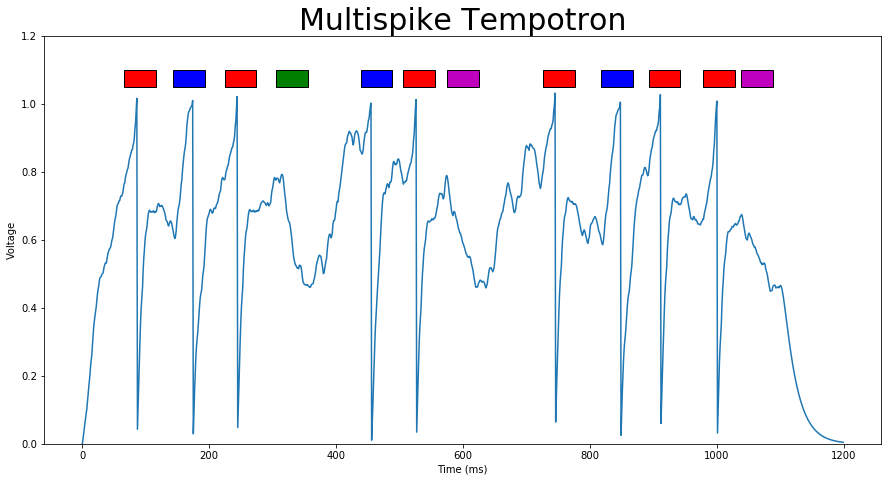

In [59]:
V_t, num_spikes, spike_time = calculate_Vt(input_data, theta, cur_omegaRB_list[99])
time = np.arange(0., len(input_data[0])+100, 1.) #ms
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Multispike Tempotron", fontsize=30)
plt.plot(time, V_t)
for marker in markers:
    plt.gca().add_patch(marker)
plt.ylim((0, 1.2))
print(num_spikes)

# 4.1 Multi features-multi spikes / learning curve

In [18]:
#elig = eligibility(data, V_t)
#desired_spikes = 5
#learning_rate = 0.01 #lambda
#updated_omega = synaptic_update(elig, random_omega, learning_rate, desired_spikes)
#V_t, num_spikes = calculate_Vt(data, theta, omega_coefficient, random_omega)
omega = np.copy(random_omega)

def correlation_training(current_omega, n_cycles, fea_idx, learning_rate):
    t1 = t.perf_counter()
    cycle = 0
    seed = 0
    cur_omega_list = []
    while cycle < n_cycles:     
        trial = cycle*100
        while seed < trial+100:
            data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)  
            desired_spikes = n_fea_occur[fea_idx] + n_fea_occur[fea_idx+1]*2 + n_fea_occur[fea_idx+2]*3 + n_fea_occur[fea_idx+3]*4 + n_fea_occur[fea_idx+4]*5
            V_t, num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
            #print('1', num_spikes, desired_spikes)
            if num_spikes != desired_spikes:
                elig = eligibility(data, V_t)
                #V_t, new_num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
                current_omega = synaptic_update(elig, current_omega, learning_rate, num_spikes, desired_spikes)
                #print('2', new_num_spikes, desired_spikes)
            seed += 1
            #print('s: '+str(seed))
        cur_omega_list.append(current_omega)
        cycle += 1
        print('c: '+str(cycle)) #+'; current_omega = '+str(current_omega))
    print(t.perf_counter()-t1)
    return cur_omega_list
cur_omegaAll_list = correlation_training(omega, 1000, 0, 0.0001)
np.save("cur_omegaAll_list", cur_omegaAll_list)

c: 1
c: 2
c: 3
c: 4
c: 5
c: 6
c: 7
c: 8
c: 9
c: 10
c: 11
c: 12
c: 13
c: 14
c: 15
c: 16
c: 17
c: 18
c: 19
c: 20
c: 21
c: 22
c: 23
c: 24
c: 25
c: 26
c: 27
c: 28
c: 29
c: 30
c: 31
c: 32
c: 33
c: 34
c: 35
c: 36
c: 37
c: 38
c: 39
c: 40
c: 41
c: 42
c: 43
c: 44
c: 45
c: 46
c: 47
c: 48
c: 49
c: 50
c: 51
c: 52
c: 53
c: 54
c: 55
c: 56
c: 57
c: 58
c: 59
c: 60
c: 61
c: 62
c: 63
c: 64
c: 65
c: 66
c: 67
c: 68
c: 69
c: 70
c: 71
c: 72
c: 73
c: 74
c: 75
c: 76
c: 77
c: 78
c: 79
c: 80
c: 81
c: 82
c: 83
c: 84
c: 85
c: 86
c: 87
c: 88
c: 89
c: 90
c: 91
c: 92
c: 93
c: 94
c: 95
c: 96
c: 97
c: 98
c: 99
c: 100
c: 101
c: 102
c: 103
c: 104
c: 105
c: 106
c: 107
c: 108
c: 109
c: 110
c: 111
c: 112
c: 113
c: 114
c: 115
c: 116
c: 117
c: 118
c: 119
c: 120
c: 121
c: 122
c: 123
c: 124
c: 125
c: 126
c: 127
c: 128
c: 129
c: 130
c: 131
c: 132
c: 133
c: 134
c: 135
c: 136
c: 137
c: 138
c: 139
c: 140
c: 141
c: 142
c: 143
c: 144
c: 145
c: 146
c: 147
c: 148
c: 149
c: 150
c: 151
c: 152
c: 153
c: 154
c: 155
c: 156
c: 157
c: 158
c:

30


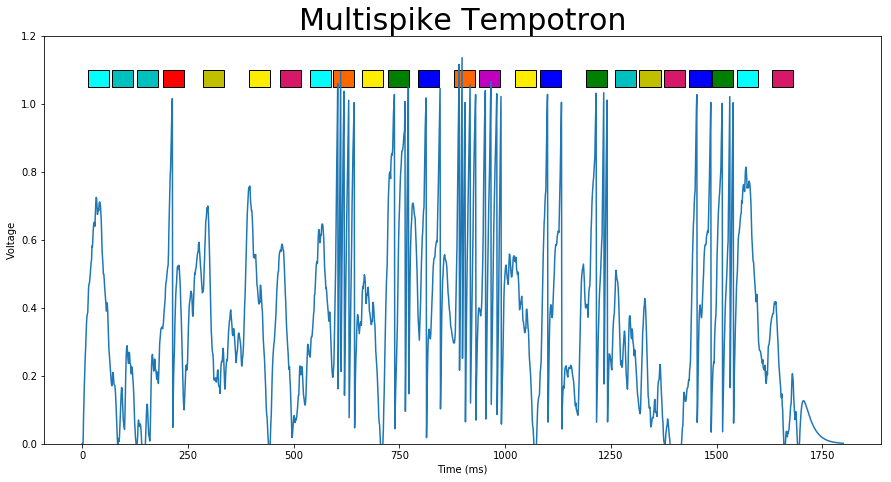

In [19]:
V_t, num_spikes, spike_time = calculate_Vt(input_data, theta, cur_omegaAll_list[999])
time = np.arange(0., len(input_data[0])+100, 1.) #ms
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Multispike Tempotron", fontsize=30)
plt.plot(time, V_t)
for marker in markers:
    plt.gca().add_patch(marker)
plt.ylim((0, 1.2))
print(num_spikes)

In [86]:
from tempfile import TemporaryFile
multifea = TemporaryFile()
np.savez(multifea, time, V_t, num_spikes)

In [26]:
R_fea_All, R_null_All = learning_curve(cur_omegaAll_list)
np.savez("multispikes_learning", R_fea_All, R_null_All)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [25]:
learning = np.load("multispikes_learning.npz")
R_fea_All, R_null_All = learning['arr_0'], learning['arr_1']

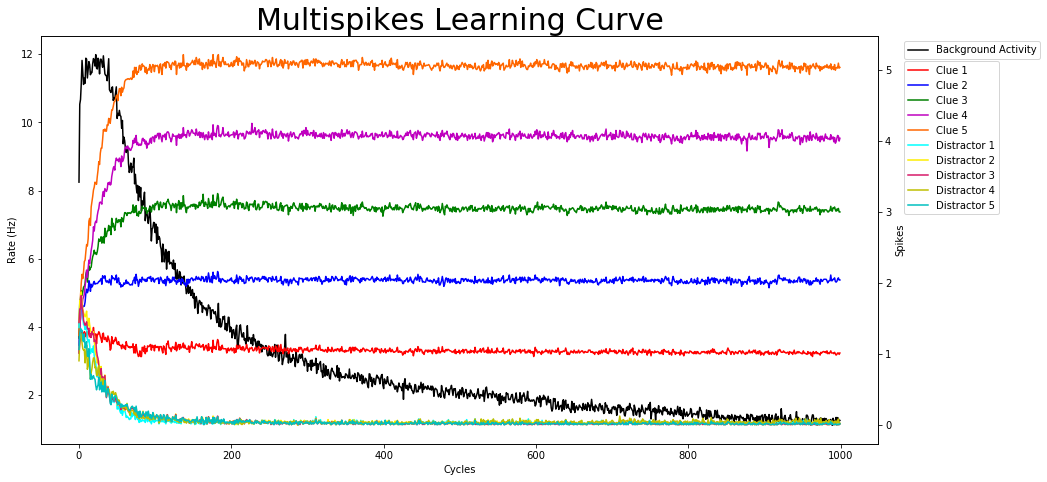

In [123]:
#learning rate of 0.0001
cycles = np.arange(0,1000,1)
fig, ax1 = plt.subplots()

color = ['r','b','g','m', '#FF6600', '#00ffff', '#FDEE00', '#D71868', 'y', 'c', 'k']
legend = ['Clue 1', 'Clue 2', 'Clue 3', 'Clue 4', 'Clue 5', 'Distractor 1', 'Distractor 2', 'Distractor 3', 'Distractor 4', 'Distractor 5']

ax2 = ax1.twinx()
ax1.plot(cycles, R_null_All, 'k', label='Background Activity')
count = 0
for fea in R_fea_All:
    ax2.plot(cycles, fea, color[count], label=legend[count])
    count += 1

ax1.set_xlabel('Cycles')
ax1.set_ylabel('Rate (Hz)')
ax2.set_ylabel('Spikes')

ax1.legend(bbox_to_anchor=(1.2, 1))
plt.legend(bbox_to_anchor=(1.15, 0.95))
plt.title("Multispikes Learning Curve", fontsize=30)
#plt.xlim(0,300)

# 5 update only once per trial for 100 cycles

In [32]:
#elig = eligibility(data, V_t)
#desired_spikes = 5
#learning_rate = 0.01 #lambda
#updated_omega = synaptic_update(elig, random_omega, learning_rate, desired_spikes)
#V_t, num_spikes = calculate_Vt(data, theta, omega_coefficient, random_omega)
omega = np.copy(random_omega)

def correlation_training(current_omega, n_cycles, fea_idx, learning_rate):
    t1 = t.perf_counter()
    cycle = 0
    seed = 0
    cur_omega_list = []
    while cycle < n_cycles:     
        trial = cycle*100
        while seed < trial+100:
            data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)  
            desired_spikes = n_fea_occur[fea_idx]
            V_t, num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
            #print('1', num_spikes, desired_spikes)
            if num_spikes != desired_spikes:
                elig = eligibility(data, V_t)
                #V_t, new_num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
                current_omega = synaptic_update(elig, current_omega, learning_rate, num_spikes, desired_spikes)
                #print('2', new_num_spikes, desired_spikes)
                #print(str(seed) + ', ' + str(current_omega[2]))
            seed += 1
            #print('s: '+str(seed))
        #import pdb; pdb.set_trace()
        cur_omega_list.append(current_omega)
        cycle += 1
        print('c: '+str(cycle)) #+'; current_omega = '+str(current_omega))
    t2 = t.perf_counter()
    return cur_omega_list, t2-t1
cur_omega_list, time = correlation_training(omega, 100, 0, 0.0001)
print(time)

c: 1
c: 2
c: 3
c: 4
c: 5
c: 6
c: 7
c: 8
c: 9
c: 10
c: 11
c: 12
c: 13
c: 14
c: 15
c: 16
c: 17
c: 18
c: 19
c: 20
c: 21
c: 22
c: 23
c: 24
c: 25
c: 26
c: 27
c: 28
c: 29
c: 30
c: 31
c: 32
c: 33
c: 34
c: 35
c: 36
c: 37
c: 38
c: 39
c: 40
c: 41
c: 42
c: 43
c: 44
c: 45
c: 46
c: 47
c: 48
c: 49
c: 50
c: 51
c: 52
c: 53
c: 54
c: 55
c: 56
c: 57
c: 58
c: 59
c: 60
c: 61
c: 62
c: 63
c: 64
c: 65
c: 66
c: 67
c: 68
c: 69
c: 70
c: 71
c: 72
c: 73
c: 74
c: 75
c: 76
c: 77
c: 78
c: 79
c: 80
c: 81
c: 82
c: 83
c: 84
c: 85
c: 86
c: 87
c: 88
c: 89
c: 90
c: 91
c: 92
c: 93
c: 94
c: 95
c: 96
c: 97
c: 98
c: 99
c: 100
1401.687347799998


In [33]:
cur_omega_list[99] - cur_omega_list[98]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.00000000e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.00000000e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e-04,   0.00000000e+00,
         2.00000000e-04,   1.00000000e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

6


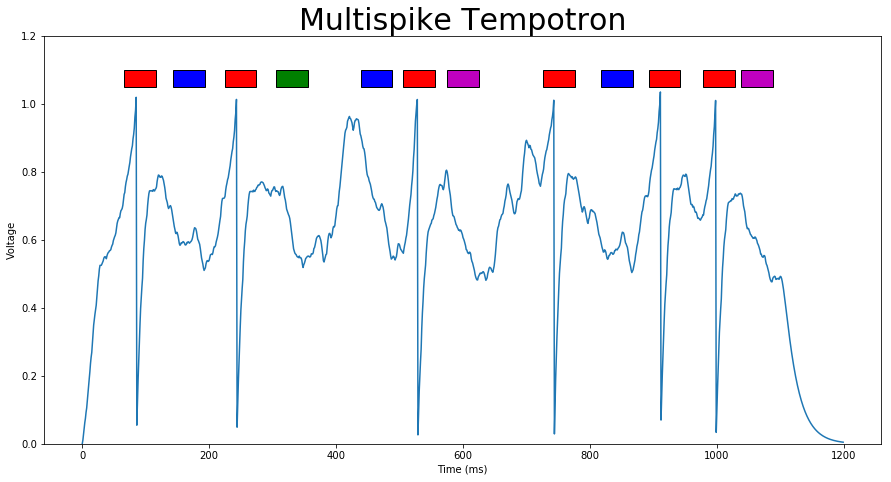

In [31]:
V_t, num_spikes, spike_time = calculate_Vt(input_data, theta, cur_omega_list[99])
time = np.arange(0., len(input_data[0])+100, 1.) #ms
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Multispike Tempotron", fontsize=30)
plt.plot(time, V_t)
for marker in markers:
    plt.gca().add_patch(marker)
plt.ylim((0, 1.2))
print(num_spikes)

# Learning curve for 1 spike per feature

### Original  

In [37]:
np.random.seed(200000)
feature = features['feature_0'] #red color
current_omega = cur_omega_list[0]
def neural_response(current_omega, feature):
    response = []
    s_null = []
    #s_fea = []
    #t1 = t.perf_counter()
    for i in range(100):
        #print(i)
        bg_data = gen_background_data(n, fr, 1.95)
        data_null = np.insert(bg_data, 975, np.zeros((50, n)), axis = 1)
        data_fea = np.insert(bg_data, 975, feature.T, axis = 1)
        num_spikes_null = calculate_Vt(data_null, theta, current_omega)[1]
        num_spikes_fea = calculate_Vt(data_fea, theta, current_omega)[1]
        response.append(num_spikes_fea - num_spikes_null)
        s_null.append(num_spikes_null)
        #s_fea.append(num_spikes_fea)
    R_fea_mean = np.mean(response)
    R_null_mean = np.mean(s_null)/2  #in Hz (divided by 2s)
    #print(t.perf_counter()-t1)
    return R_fea_mean, R_null_mean
#R_fea_mean, R_null_mean = neural_response(current_omega, feature)
#print(R_fea_mean, R_null_mean)

### Alternative 

In [43]:
#np.random.seed(200000)
#current_omega = cur_omega_list[0]
def neural_response(current_omega, feature):
    response = 0
    s_null = 0
    #s_fea = []
    #t1 = t.perf_counter()
    for i in range(100):
        #print(i)
        bg_data = gen_background_data(n, fr, 1.95)
        data_null = np.insert(bg_data, 975, np.zeros((50, n)), axis = 1)
        data_fea = np.insert(bg_data, 975, feature.T, axis = 1)
        num_spikes_null = calculate_Vt(data_null, theta, current_omega)[1]
        num_spikes_fea = calculate_Vt(data_fea, theta, current_omega)[1]
        response += num_spikes_fea - num_spikes_null
        s_null += num_spikes_null
        #s_fea.append(num_spikes_fea)
    R_fea_mean = response/100
    R_null_mean = s_null/200  #in Hz (divided by 2s)
    #print(t.perf_counter()-t1)
    return R_fea_mean, R_null_mean
#R_fea_mean, R_null_mean = neural_response(current_omega, feature)
#print(R_fea_mean, R_null_mean)

### One spike /feature 

In [32]:
cur_omega_list = np.load("cur_omega_list.npy")

## Latest code for neural response and learning curve

In [25]:
#np.random.seed(200000)
#current_omega = cur_omega_list[0]
def neural_response(current_omega, features):
    response = {}
    R_fea_mean = []
    s_null = 0
    #t1 = t.perf_counter()
    for i in range(100):
        #print(i)
        bg_data = gen_background_data(n, fr, 1.95)
        data_null = np.insert(bg_data, 975, np.zeros((50, n)), axis = 1)
        num_spikes_null = calculate_Vt(data_null, theta, current_omega)[1]
        s_null += num_spikes_null
        for feature in features:
            data_fea = np.insert(bg_data, 975, features[feature].T, axis = 1)
            num_spikes_fea = calculate_Vt(data_fea, theta, current_omega)[1]
            if feature in response:
                response[feature] += num_spikes_fea - num_spikes_null
            else:
                response[feature] = num_spikes_fea - num_spikes_null
    for feature in response: 
        R_fea_mean.append(response[feature]/100)
    R_null_mean = s_null/200  #in Hz (divided by 2s)
    #print(t.perf_counter()-t1)
    return R_fea_mean, R_null_mean
#R_fea_mean, R_null_mean = neural_response(current_omega, features)
#print(R_fea_mean, R_null_mean)

In [24]:
def learning_curve(cur_omega_list):
    R_fea_list = []
    R_null_list = []
    s = 0
    t1 = t.perf_counter()
    for omega in cur_omega_list:
        s += 1
        print(s)
        R_fea_mean, R_null_mean = neural_response(omega, features)
        R_fea_list = np.append(R_fea_list, R_fea_mean)
        R_null_list = np.append(R_null_list, R_null_mean)
    R_fea_list = R_fea_list.reshape(len(cur_omega_list), len(R_fea_mean)).T
    print(t.perf_counter()-t1)
    return R_fea_list, R_null_list

In [35]:
R_fea_list, R_null_list = learning_curve(cur_omega_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
8384.141628401005


In [37]:
np.savez("1_spike_learning", R_fea_list, R_null_list)

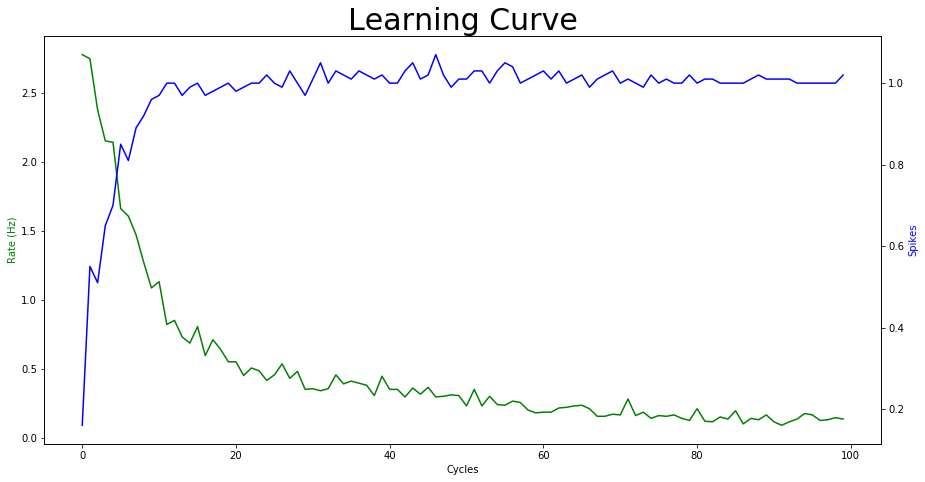

In [38]:
#learning rate of 0.0001
cycles = np.arange(0,100,1)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(cycles, R_null_list, 'g-')
ax2.plot(cycles, R_fea_list, 'b-')

ax1.set_xlabel('Cycles')
ax1.set_ylabel('Rate (Hz)', color='g')
ax2.set_ylabel('Spikes', color='b')

plt.title("Learning Curve", fontsize=30)

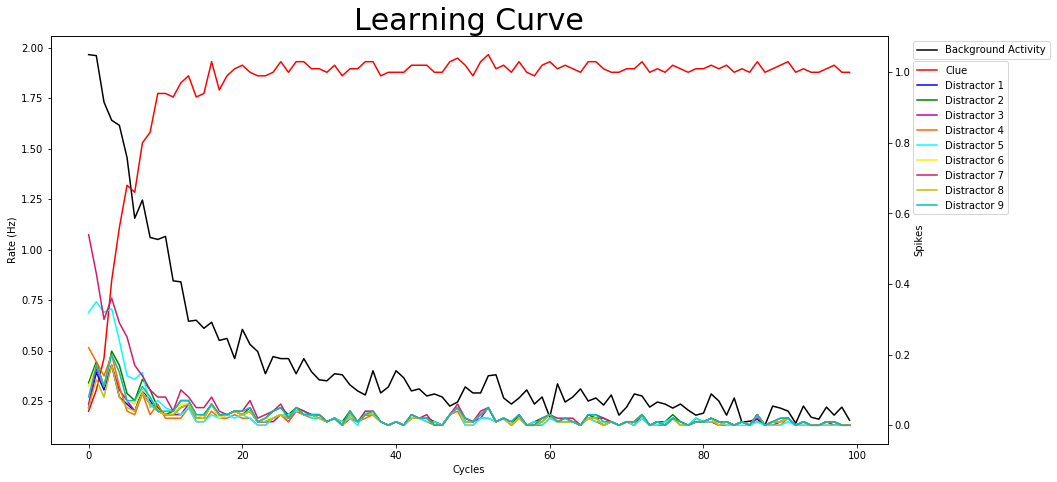

In [58]:
#learning rate of 0.0001
one_spike_learning = np.load('1_spike_learning.npz')
R_fea_list, R_null_list = one_spike_learning['arr_0'], one_spike_learning['arr_1']

cycles = np.arange(0,100,1)
fig, ax1 = plt.subplots()

color = ['r','b','g','m', '#FF6600', '#00ffff', '#FDEE00', '#D71868', 'y', 'c', 'k']
legend = ['Clue', 'Distractor 1', 'Distractor 2', 'Distractor 3', 'Distractor 4', 'Distractor 5', 'Distractor 6', 'Distractor 7', 'Distractor 8', 'Distractor 9']

ax2 = ax1.twinx()
ax1.plot(cycles, R_null_list, 'k', label = 'Background Activity')
count = 0
for fea in R_fea_list:
    ax2.plot(cycles, fea, color[count], label = legend[count])
    count += 1

ax1.set_xlabel('Cycles')
ax1.set_ylabel('Rate (Hz)')
ax2.set_ylabel('Spikes')

ax1.legend(bbox_to_anchor=(1.2, 1))
plt.legend(bbox_to_anchor=(1.15, 0.95))
plt.title("Learning Curve", fontsize=30)

# Learning curve by data sets

In [ ]:
fea_idx = 0 #red color
current_omega = cur_omega_list[0]

def neural_response(current_omega, fea_idx):
    spikes_per_fea = []
    s_null = []
    #s_fea = []
    #t1 = t.perf_counter()
    for seed in np.random.random(100)*100000000:
        #print(seed)
        num_spikes_fea = 0
        input_data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)
        V_t, num_spikes, spike_time = calculate_Vt(input_data, theta, current_omega)
        for time in fea_time[np.where(fea_order==fea_idx)]:
            for spike in spike_time:
                if spike in range(time, time+50):
                    num_spikes_fea += 1
        s_per_fea = num_spikes_fea/n_fea_occur[fea_idx]
        spikes_per_fea.append(s_per_fea)
        s_null_rate = (num_spikes - num_spikes_fea)/(input_data.shape[1] - n_fea_occur[fea_idx]*50)
        s_null.append(s_null_rate)
        #s_fea.append(num_spikes_fea)
    R_fea_mean = np.mean(spikes_per_fea)
    R_null_mean = np.mean(s_null)  
    #print(t.perf_counter()-t1)
    return R_fea_mean, R_null_mean
#R_fea_mean, R_null_mean = neural_response(current_omega, feature)
#print(R_fea_mean, R_null_mean)

In [ ]:
def learning_curve(cur_omega_list):
    R_fea_list = []
    R_null_list = []
    s = 0
    t1 = t.perf_counter()
    for omega in cur_omega_list:
        s += 1
        print(s)
        R_fea_mean, R_null_mean = neural_response(omega, feature)
        R_fea_list.append(R_fea_mean)
        R_null_list.append(R_null_mean)
    print(t.perf_counter()-t1)
    return R_fea_list, R_null_list
R_fea_list, R_null_list = learning_curve(cur_omega_list)

# Learning curve for 5 spikes per feature

In [84]:
feature = features['feature_0'] #red color
current_omega = cur_omega_list[29]
def neural_response(current_omega, feature):
    response = []
    s_null = []
    #s_fea = []
    #t1 = t.perf_counter()
    for i in range(100):
        #print(i)
        bg_data = gen_background_data(n, fr, 1.95)
        data_null = np.insert(bg_data, 975, np.zeros((50, n)), axis = 1)
        data_fea = np.insert(bg_data, 975, feature.T, axis = 1)
        num_spikes_null = calculate_Vt(data_null, theta, current_omega)[1]
        num_spikes_fea = calculate_Vt(data_fea, theta, current_omega)[1]
        response.append(num_spikes_fea - num_spikes_null)
        s_null.append(num_spikes_null)
        #s_fea.append(num_spikes_fea)
    R_fea_mean = np.mean(response)
    R_null_mean = np.mean(s_null)/2  #in Hz (divided by 2s)
    #print(t.perf_counter()-t1)
    return R_fea_mean, R_null_mean
#R_fea_mean, R_null_mean = neural_response(current_omega, feature)
#print(R_fea_mean, R_null_mean)

In [52]:
def learning_curve(cur_omega_list):
    R_fea_list = []
    R_null_list = []
    s = 0
    t1 = t.perf_counter()
    for omega in cur_omega_list:
        s += 1
        print(s)
        R_fea_mean, R_null_mean = neural_response(omega, feature)
        R_fea_list.append(R_fea_mean)
        R_null_list.append(R_null_mean)
    print(t.perf_counter()-t1)
    return R_fea_list, R_null_list
R_fea_list, R_null_list = learning_curve(cur_omega5_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
1725.8698353669606


In [89]:
np.savez("5_spikes_learning", R_fea_list, R_null_list)

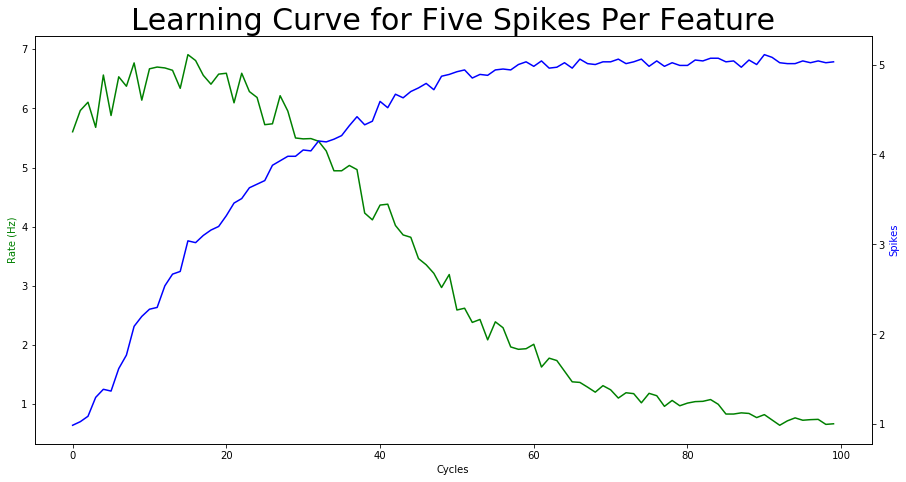

In [55]:
#learning rate of 0.0001
cycles = np.arange(0,100,1)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(cycles, R_null_list, 'g-')
ax2.plot(cycles, R_fea_list, 'b-')

ax1.set_xlabel('Cycles')
ax1.set_ylabel('Rate (Hz)', color='g')
ax2.set_ylabel('Spikes', color='b')

plt.title("Learning Curve for Five Spikes Per Feature", fontsize=30)

# Multi-Spike Tempotron Algorithm (Theta Critical Gradient)

[[0 0 1 ..., 0 1 0]
 [1 1 1 ..., 0 0 1]
 [1 0 0 ..., 1 1 1]
 [0 0 0 ..., 1 1 1]
 [0 0 1 ..., 0 0 1]]
[ 0.00948951  0.01677219  0.01643535  0.02579509  0.00403931]


(0, 1.2)

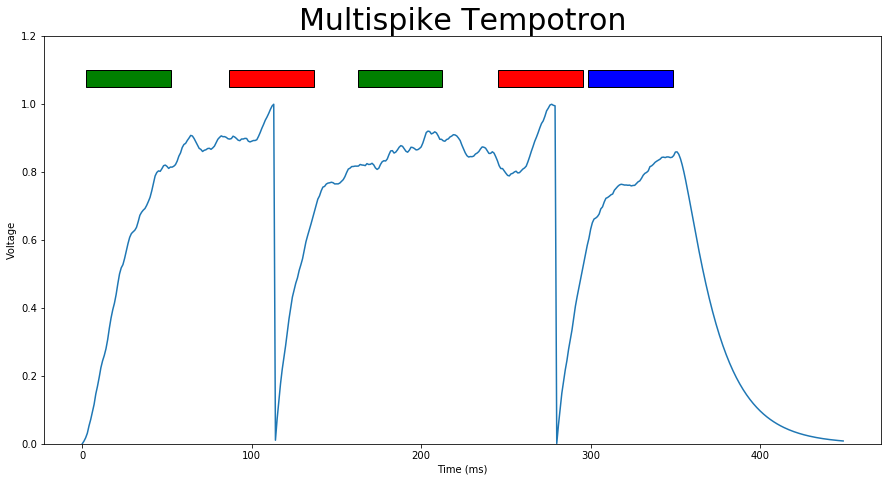

In [426]:
n = 5
seed = 2500
n_fea = 3 #number of different features
cf_mean = 2 #mean for number of occurrences for each feature
fr = 500 #average firing rate of each input neuron (Hz)
T_null = 0.1 #background activity duration (s)
T_fea = 0.05 #T_fea: feature duration (s)
dt = 0.001 #bin (s)
marker_y = 1.05
marker_height = 0.05
omega_coefficient = 0.022*1.5
omega = gen_omega(n, omega_coefficient)
data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)  
print(data)
print(omega)

V_t, num_spikes, spike_time, a = calculate_Vt(data, 1, cur_omegaMulti_list[5])#[ 0.00513917,  0.01471243,  0.01345423,  0.02598373,  0.00348564])
time = np.arange(0., len(data[0])+100, 1.) #ms
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Multispike Tempotron", fontsize=30)
plt.plot(time, V_t)
for marker in markers:
    plt.gca().add_patch(marker)
plt.ylim((0, 1.2))


In [315]:
def STS(data, theta, omega):
    num_spikes = 0
    data = np.concatenate((data, np.zeros((n, 100))), axis=1)
    kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
    kernel_array = np.zeros((n,len(data[0])))
    V_t = np.zeros(len(data[0]))
    exp = np.exp(-np.arange(0, data.shape[1])/tau_mem)
    sum_time_exp = np.zeros(len(data[0]))
    unresetted_V = []
    spike_time = []
    for neuron, ith_bin in zip(*np.where(data)):
        kernel_array[neuron, ith_bin:] += np.multiply(kernel, omega[neuron])[:len(kernel)-ith_bin]
    tot_input = kernel_array.sum(axis=0)
    for ith_bin in range(data.shape[1]):
        V_t[ith_bin] = V_rest + tot_input[ith_bin] - theta*sum_time_exp[ith_bin]  #calculate V(t)
        if V_t[ith_bin] >= theta:
            unresetted_V.append(V_t[ith_bin])
            V_t[ith_bin] -= theta
            num_spikes += 1
            spike_time.append(ith_bin)
            sum_time_exp[ith_bin:] += exp[:len(data[0])-ith_bin]
    return num_spikes, spike_time, unresetted_V
num_spikes, spike_time, unresetted_V = STS(data, theta_critical-0.0000001, omega)
print(spike_time, unresetted_V)

[32, 71, 98, 136, 174, 224, 271, 320, 361, 393, 428, 476, 515, 551, 593] [1.0296884608933254, 1.0200881375655386, 1.0222326624328084, 1.0094281490745065, 1.0094096771476919, 1.0136308953957001, 1.0182431492143389, 1.0088287098936886, 1.0104643554094528, 1.0184436648977038, 1.0107400965039097, 1.0110218306227223, 1.0171795193719095, 1.0163890007931013, 1.0116708841295674]


In [24]:
def max_Vt(data, theta, omega):
    num_spikes = 0
    data = np.concatenate((data, np.zeros((n, 100))), axis=1)
    kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
    kernel_array = np.zeros((n,len(data[0])))
    V_t = np.zeros(len(data[0]))
    exp = np.exp(-np.arange(0, data.shape[1])/tau_mem)
    sum_time_exp = np.zeros(len(data[0]))
    spike_time = []
    for neuron, ith_bin in zip(*np.where(data)):
        kernel_array[neuron, ith_bin:] += np.multiply(kernel, omega[neuron])[:len(kernel)-ith_bin]
    tot_input = kernel_array.sum(axis=0)
    for ith_bin in range(data.shape[1]):
        V_t[ith_bin] = V_rest + tot_input[ith_bin] - theta*sum_time_exp[ith_bin]  #calculate V(t)
        if V_t[ith_bin] >= theta:
            V_t[ith_bin] -= theta
            num_spikes += 1
            spike_time.append(ith_bin)
            sum_time_exp[ith_bin:] += exp[:len(data[0])-ith_bin]
    return max(V_t)

In [312]:
### for 2nd version of theta_critical fn ###
theta_range = [0, 5]
smallest_range = 0.0000000001 #actual interval = smallest_theta_range/2
theta_spikes = 15

def bisect(data, theta_spikes, theta_range, smallest_range, omega):
    theta_list = [theta_range[0], sum(theta_range)/2, theta_range[1]]
    high = STS(data, theta_range[0], omega)
    medium = STS(data, sum(theta_range)/2, omega)
    low = STS(data, theta_range[1], omega)
    spike_list = [high[0], medium[0], low[0]]
    if theta_list[2] - theta_list[0] >= smallest_range:
        if theta_spikes <= spike_list[0] and theta_spikes > spike_list[1]:
            theta_range = [theta_list[0], theta_list[1]]
        elif theta_spikes <= spike_list[1] and theta_spikes > spike_list[2]:
            theta_range = [theta_list[1], theta_list[2]]
        mid_theta, mid_spike, mid_spike_t, mid_V = bisect(data, theta_spikes, theta_range, smallest_range, omega)
        return sorted(np.append(theta_list, mid_theta[1:-1]), reverse=True), sorted(np.append(spike_list, mid_spike[1:-1])), mid_spike_t, mid_V 
    else:
        spike_t_list = [low[1], medium[1], high[1]]
        unresetted_V = [low[2], medium[2], high[2]]
        return theta_list, spike_list, spike_t_list, unresetted_V
t1 = t.perf_counter()
theta_list, spike_list, spike_t_list, unresetted_V = bisect(data, theta_spikes, theta_range, smallest_range, omega)
print(theta_list, spike_list, spike_t_list, unresetted_V)
print(t.perf_counter()-t1)

[5.0, 2.5, 1.25, 1.09375, 1.015625, 1.0107421875, 1.009521484375, 1.0089111328125, 1.0088348388671875, 1.0088300704956055, 1.00882887840271, 1.008828729391098, 1.0088287107646465, 1.0088287061080337, 1.0088287037797272, 1.008828702615574, 1.0088287023245357, 1.0088287021790165, 1.0088287021426368, 1.008828702106257, 1.0088287020334974, 1.0088287014514208, 1.008828692138195, 1.0088286548852921, 1.0088285803794861, 1.0088282823562622, 1.0088276863098145, 1.0088253021240234, 1.0088157653808594, 1.0087966918945312, 1.008758544921875, 1.00860595703125, 1.00830078125, 1.005859375, 0.99609375, 0.9765625, 0.9375, 0.625, 0.0] [0, 0, 2, 10, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 18, 38, 700] [[32, 71, 98, 136, 174, 224, 271, 325, 370, 397, 449, 491, 534, 573], [32, 71, 98, 136, 174, 224, 271, 320, 361, 393, 428, 476, 515, 551, 593], [32, 71, 98, 136, 174, 224, 271, 320, 361, 393, 428, 476, 515, 551, 593]] [[

In [317]:
### for 3rd version of theta_critical fn --> return less results (for more precise calculation of t_star) ###
theta_range = [0, 5]
smallest_range = 0.000001 #actual interval = smallest_theta_range/2
theta_spikes = 15

def bisect(data, theta_spikes, theta_range, smallest_range, omega):
    theta_list = [theta_range[0], sum(theta_range)/2, theta_range[1]]
    high = STS(data, theta_range[0], omega)
    medium = STS(data, sum(theta_range)/2, omega)
    low = STS(data, theta_range[1], omega)
    spike_list = [high[0], medium[0], low[0]]
    if theta_list[2] - theta_list[0] >= smallest_range:
        if theta_spikes <= spike_list[0] and theta_spikes > spike_list[1]:
            theta_range = [theta_list[0], theta_list[1]]
        elif theta_spikes <= spike_list[1] and theta_spikes > spike_list[2]:
            theta_range = [theta_list[1], theta_list[2]]
        mid_theta, mid_spike = bisect(data, theta_spikes, theta_range, smallest_range, omega)
        return sorted(np.append(theta_list, mid_theta[1:-1]), reverse=True), sorted(np.append(spike_list, mid_spike[1:-1])) 
    else:
        return theta_list, spike_list
t1 = t.perf_counter()
theta_list, spike_list = bisect(data, theta_spikes, theta_range, smallest_range, omega)
print(theta_list, spike_list)
print(t.perf_counter()-t1)

[5.0, 2.5, 1.25, 1.09375, 1.015625, 1.0107421875, 1.009521484375, 1.0089111328125, 1.0088348388671875, 1.0088300704956055, 1.00882887840271, 1.0088285803794861, 1.0088282823562622, 1.0088276863098145, 1.0088253021240234, 1.0088157653808594, 1.0087966918945312, 1.008758544921875, 1.00860595703125, 1.00830078125, 1.005859375, 0.99609375, 0.9765625, 0.9375, 0.625, 0.0] [0, 0, 2, 10, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 18, 38, 700]
1.0389469000001554


In [368]:
theta_range = [0.5, 1.5]
smallest_range = 0.0001 #actual interval = smallest_theta_range/2
theta_spikes = 4

def bisect(data, theta_spikes, theta_range, smallest_range, omega):
    theta_list = [theta_range[0], sum(theta_range)/2, theta_range[1]]
    spike_list = [STS(data, theta_range[0], omega)[0], STS(data, sum(theta_range)/2, omega)[0], STS(data, theta_range[1], omega)[0]]
    if theta_list[2] - theta_list[0] >= smallest_range:
        if theta_spikes <= spike_list[0] and theta_spikes > spike_list[1]:
            theta_range = [theta_list[0], theta_list[1]]
        elif theta_spikes <= spike_list[1] and theta_spikes > spike_list[2]:
            theta_range = [theta_list[1], theta_list[2]]
        mid_theta, mid_spike = bisect(data, theta_spikes, theta_range, smallest_range, omega)
        return sorted(np.append(theta_list, mid_theta[1:-1]), reverse=True), sorted(np.append(spike_list, mid_spike[1:-1]))
    else:
        return theta_list, spike_list
t1 = t.perf_counter()
print(bisect(data, theta_spikes, theta_range, smallest_range, omega))
print(t.perf_counter()-t1)

([1.5, 1.25, 1.125, 1.0625, 1.03125, 1.0234375, 1.0224609375, 1.02197265625, 1.021728515625, 1.0216064453125, 1.02154541015625, 1.021514892578125, 1.021484375, 1.01953125, 1.015625, 1.0, 0.5], [0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 56])
1.5966400260222144


In [674]:
def fun(x):
    return x - max(STS(data, x, omega))

sol = optimize.root(fun, 0.77681350708007812)#, 0.7768096923828125)
print(sol)
#print(fun(0.776809867839))

    fjac: array([[-1.]])
     fun: array([  1.11022302e-16])
 message: 'The solution converged.'
    nfev: 4
     qtf: array([ -1.33226763e-14])
       r: array([-1.00682073])
  status: 1
 success: True
       x: array([ 0.77680989])


In [772]:
def fun(x):
    return [(x[0] - max_Vt(data, x[0], omega)), (x[1] - max_Vt(data, x[1], omega))]

sol = optimize.root(fun, [0.83198928833007812, 0.8319854736328125])#, 0.7768096923828125)
print(sol)
#print(fun(0.776809867839))

    fjac: array([[ 0.97227766,  0.2338293 ],
       [-0.2338293 ,  0.97227766]])
     fun: array([  3.70403174e-05,   5.55448576e-10])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([  3.60136032e-05,  -8.66057153e-06])
       r: array([ -5.18676888e+00,   3.74341721e+05,  -9.43010885e+04])
  status: 1
 success: True
       x: array([ 0.83202353,  0.82724057])


In [283]:
def root_fun(x, data, w):
    V_max = max_Vt(data, x[0], w)
    return [x[0] - V_max, V_max - x[1]]

sol = optimize.root(root_fun, [1.0055109854403099, 1.0055109854400257], args=(data, w))
print(sol)
#print(fun(0.776809867839))

    fjac: array([[-0.99973612,  0.02297131],
       [-0.02297131, -0.99973612]])
     fun: array([  2.43138842e-13,   4.10782519e-14])
 message: 'The solution converged.'
    nfev: 4
     qtf: array([ -2.42131063e-13,  -4.66526296e-14])
       r: array([-1.0237879 , -0.02297131,  0.99973613])
  status: 1
 success: True
       x: array([ 1.00551099,  1.00551099])


In [101]:
sol.x*10000000

array([ 11225712.74724875,  11225712.74724875])

In [ ]:
### use brentq to find root, minus the lowest unresetted V ###


In [744]:
def fun(x):
    return max_Vt(data, x, omega)

#sol = optimize.root(fun, 0.77681350708007812)#, 0.7768096923828125)
#print(sol)
print(fun(0.74838085))

0.748380849804


In [631]:
def fun(x):
    return [x[0]**2-5, 10-x[1]**2]
sol = optimize.root(fun, [10,-10])
print(sol)

    fjac: array([[ 0.29299464, -0.95611408],
       [ 0.95611408,  0.29299464]])
     fun: array([  1.12017062e-11,   1.19921850e-11])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([  6.98937555e-09,  -1.21510602e-08])
       r: array([ 3.76980665, -9.29170345,  7.49403749])
  status: 1
 success: True
       x: array([ 2.23606798, -3.16227766])


In [26]:
###original###
def theta_critical(data, num_spikes, desired_spikes, theta_range, smallest_range, omega):
    if num_spikes > desired_spikes:
        theta_spikes = num_spikes
    elif num_spikes < desired_spikes:
        theta_spikes = num_spikes + 1
    theta_list, spike_list, spike_t_list = bisect(data, theta_spikes, theta_range, smallest_range, omega)
    theta_critical = theta_list[spike_list.index(theta_spikes)]
    a = list(set(spike_t_list[1]) ^ set(spike_t_list[0]))
    if a:
        assert (len(a) == 1), "t_star is not precise enough, decrease your smallest_range!"
        t_star_list = spike_t_list[1][:spike_t_list[1].index(a[0])+1]
    else:
        a = list(set(spike_t_list[1]) ^ set(spike_t_list[2]))
        assert (len(a) == 1), "t_star is not precise enough, decrease your smallest_range!"
        t_star_list = spike_t_list[2][:spike_t_list[2].index(a[0])+1]
    return theta_critical, t_star_list

#theta_critical, t_star_list = theta_critical(data, 5, 3, theta_range, smallest_range, omega)
#print(theta_critical, t_star_list)

In [174]:
### 2nd version: lowest V among the unresetted time bin at spike ###
def theta_critical(data, num_spikes, desired_spikes, theta_range, smallest_range, omega):
    if num_spikes > desired_spikes:
        theta_spikes = num_spikes
    elif num_spikes < desired_spikes:
        theta_spikes = num_spikes + 1
    theta_list, spike_list, spike_t_list, unresetted_V = bisect(data, theta_spikes, theta_range, smallest_range, omega)
    theta_critical = theta_list[spike_list.index(theta_spikes)]
    if len(spike_t_list[0]) == len(spike_t_list[1]):
        t_star_list = spike_t_list[2][:unresetted_V[2].index(min(unresetted_V[2]))+1]
    else:
        t_star_list = spike_t_list[1][:unresetted_V[1].index(min(unresetted_V[1]))+1]
    return theta_critical, t_star_list

theta_critical, t_star_list = theta_critical(data, 7, 3, theta_range, smallest_range, omega)
print(theta_critical, t_star_list)

1.12257127472 [46, 124, 198, 252]


In [321]:
### 3rd version: lowest V among the unresetted time bin at spike and use root to find theta_critical ###
def theta_critical(data, num_spikes, desired_spikes, theta_range, smallest_range, omega):
    if num_spikes > desired_spikes:
        theta_spikes = num_spikes
    elif num_spikes < desired_spikes:
        theta_spikes = num_spikes + 1
    theta_list, spike_list = bisect(data, theta_spikes, theta_range, smallest_range, omega)
    theta_critical_range = optimize.root(root_fun, [theta_list[spike_list.index(theta_spikes)-1], theta_list[spike_list.index(theta_spikes)]], args=(data, omega)).x 
    assert (theta_critical_range[0] - theta_critical_range[1] < 0.00001), "Root not converged!"
    new_V = STS(data, theta_critical_range[1], omega)
    t_star_list = new_V[1][:new_V[2].index(min(new_V[2]))+1]
    return theta_critical_range[1], t_star_list

#theta_critical, t_star_list = theta_critical(data, 15, 3, theta_range, 0.00001, omega)
#print(theta_critical, t_star_list)

In [557]:
b = list(set(spike_t_list[1]) - set(spike_t_list[0]))
c = []
if c:
    print('T')
else:
    print('F')
print(len(b))
#print(b[0])
#print(spike_t_list[1][:spike_t_list[1].index(b[0])+1])

F
0


In [449]:
def calculate_Vt(data, theta, omega):
    num_spikes = 0
    data = np.concatenate((data, np.zeros((n, 100))), axis=1)
    kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
    kernel_array = np.zeros((n,len(data[0])))
    plain_kernel = np.zeros((n,len(data[0])))
    V_t = np.zeros(len(data[0]))
    exp = np.exp(-np.arange(0, data.shape[1])/tau_mem)
    sum_time_exp = np.zeros(len(data[0]))
    spike_time = []
    #t5 = t.perf_counter()
    for neuron, ith_bin in zip(*np.where(data)):
        #plain_kernel[neuron, ith_bin:] += kernel[:len(kernel)-ith_bin]
        kernel_array[neuron, ith_bin:] += np.multiply(kernel, omega[neuron])[:len(kernel)-ith_bin]
    #print(t.perf_counter()-t5)    
    tot_input = kernel_array.sum(axis=0)
    for ith_bin in range(data.shape[1]):
        V_t[ith_bin] = V_rest + tot_input[ith_bin] - theta*sum_time_exp[ith_bin]  #calculate V(t)
        if V_t[ith_bin] >= theta:
            V_t[ith_bin] -= theta
            num_spikes += 1
            spike_time.append(ith_bin)
            sum_time_exp[ith_bin:] += exp[:len(data[0])-ith_bin]
    #print(t.perf_counter()-t5)
    return V_t, num_spikes, spike_time, sum_time_exp#, plain_kernel, tot_input

t1 = t.perf_counter()
V_t, num_spikes, spike_time, sum_time_exp = calculate_Vt(data, 1, cur_omegaMulti_list[5])
print(t.perf_counter()-t1)
print("number of spikes: " + str(num_spikes))
print(spike_time)

0.008726395986741409
number of spikes: 2
[114, 280]


0.0071009900129865855
2 [114, 281]


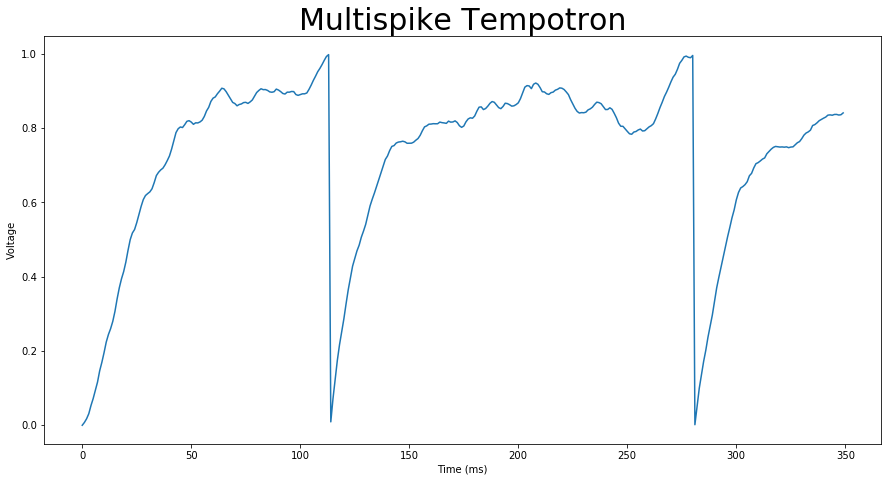

In [450]:
### Alex's voltage calculation code -- version 1 ####

def get_memory_len(kernel_array, ratio=0.01):
    """
    Return the number of time bins until kernel_array has decreased by the factor 'ratio'
    'kernel_array' may initially rise, but must be monotonically decreasing from 
    the maximum.
    """
    arr = (kernel_array - ratio*kernel_array.max())[::-1]
        # The point where this array reaches zero is the desired memory time
        # We flip the order with [::-1] because np.searchsorted expects increasing order
    memory_len = len(kernel_array) - np.searchsorted(arr, 0)
    return memory_len

def find_first_spike(V, threshold):
    # Based on the equivalent code to py_find_1st (https://github.com/roebel/py_find_1st)
    ind = np.flatnonzero(V >= threshold)
    if len(ind):
        return ind[0]
    else:
        return -1

def calculate_Vt(data, theta, omega):
    global syn_tot_time, ref_tot_time
    
    num_spikes = 0
    datalen = len(data[0])
    # Allocate the voltage trace array
    V = np.zeros(datalen)

    # Create the synaptic kernel, and then remove the negligible tail
    syn_kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
    syn_memory_len = get_memory_len(kernel, ratio=0.01)
        # synaptic memory length
    syn_kernel = syn_kernel[:syn_memory_len]

    # Create the refractory kernel, and then remove the negligible tail
    ref_kernel = np.exp(- np.arange(datalen) / tau_mem)
    ref_memory_len = get_memory_len(ref_kernel, ratio=0.01)
        # synaptic memory length
    ref_kernel = ref_kernel[:ref_memory_len]
    
    # Insert a copy of the kernel for every incoming spike
    #t1 = time.perf_counter()
    for neuron, ith_bin in zip(*np.where(data)):
        mem_len = min(syn_memory_len, datalen - ith_bin)
        V[ith_bin:ith_bin+mem_len] += omega[neuron] * syn_kernel[:mem_len]
    #t2 = time.perf_counter()
    #syn_tot_time += t2-t1
    
    #t1 = time.perf_counter()
    spike_time = []
    done = False
    while not done:
        spike_idx = find_first_spike(V, theta)
        if spike_idx == -1:
            done = True
        else:
            num_spikes += 1
            spike_time.append(spike_idx)
            mem_len = min(ref_memory_len, datalen - spike_idx)
            V[spike_idx:spike_idx+mem_len] -= theta * ref_kernel[:mem_len]
    #t2 = time.perf_counter()
    #ref_tot_time += t2-t1
            
    return V, num_spikes, spike_time

t1 = t.perf_counter()
V, num_spikes, spike_time = calculate_Vt(data, 1, cur_omegaMulti_list[5])
print(t.perf_counter()-t1)
print(num_spikes, spike_time)

time = np.arange(0., len(data[0]), 1.) #ms
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Multispike Tempotron", fontsize=30)
plt.plot(time, V)
#plt.ylim((0, 1.2))

In [452]:
### Alex's voltage calculation code -- version 2 (pre-compute the kernel) ###

datalen = data.shape[1]
# Create the synaptic kernel, and then remove the negligible tail
syn_kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
syn_memory_len = get_memory_len(syn_kernel, ratio=0.001)
    # synaptic memory length
syn_kernel = syn_kernel[:syn_memory_len]

# Create the refractory kernel, and then remove the negligible tail
ref_kernel = np.exp(- np.arange(datalen) / tau_mem)
ref_memory_len = get_memory_len(ref_kernel, ratio=0.001)
    # synaptic memory length
ref_kernel = ref_kernel[:ref_memory_len]
    
# Precompute the unweighted input - this is unaffected by a change in weights
# Ultimately this should be returned by gen_input_data along with, or instead of, 'data'.
presyn_input = np.zeros(data.shape)
for neuron, ith_bin in zip(*np.where(data)):
    mem_len = min(syn_memory_len, datalen - ith_bin)
    presyn_input[neuron,ith_bin:ith_bin+mem_len] += syn_kernel[:mem_len]

def get_memory_len(kernel_array, ratio=0.01):
    """
    Return the number of time bins until kernel_array has decreased by the factor 'ratio'
    'kernel_array' may initially rise, but must be monotonically decreasing from 
    the maximum.
    """
    arr = (kernel_array - ratio*kernel_array.max())[::-1]
        # The point where this array reaches zero is the desired memory time
        # We flip the order with [::-1] because np.searchsorted expects increasing order
    memory_len = len(kernel_array) - np.searchsorted(arr, 0)
    return memory_len

def find_first_spike(V, threshold):
    # Based on the equivalent code to py_find_1st (https://github.com/roebel/py_find_1st)
    ind = np.flatnonzero(V >= threshold)
    if len(ind):
        return ind[0]
    else:
        return -1

def calculate_Vt(unweighted_input, theta, omega, version=2):
    global syn_tot_time, ref_tot_time
    
    num_spikes = 0
    # Allocate the voltage trace array
    #V = np.zeros(datalen)

    # Insert a copy of the kernel for every incoming spike
    #t1 = time.perf_counter()
    if version == 1:
        V = np.zeros(datalen)
        for neuron, ith_bin in zip(*np.where(data)):
            mem_len = min(syn_memory_len, datalen - ith_bin)
            V[ith_bin:ith_bin+mem_len] += omega[neuron] * syn_kernel[:mem_len]
    else:
        V = (omega[:,np.newaxis] * presyn_input).sum(axis=0)
    #t2 = time.perf_counter()
    #syn_tot_time += t2-t1
    
    #t1 = time.perf_counter()
    spike_time = []
    done = False
    while not done:
        spike_idx = find_first_spike(V, theta)
        if spike_idx == -1:
            done = True
        else:
            num_spikes += 1
            spike_time.append(spike_idx)
            mem_len = min(ref_memory_len, datalen - spike_idx)
            V[spike_idx:spike_idx+mem_len] -= theta * ref_kernel[:mem_len]
    #t2 = time.perf_counter()
    #ref_tot_time += t2-t1
            
    return V, num_spikes, spike_time

t1 = t.perf_counter()
V, num_spikes, spike_time = calculate_Vt(data, 1, cur_omegaMulti_list[5])
print(t.perf_counter()-t1)
print(num_spikes, spike_time)
print(syn_memory_len)
print(ref_memory_len)

0.00025398898287676275
2 [114, 280]
154
139


In [453]:
V_t[:350] - V

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.93889390e-18,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -2.77555756e-17,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.55111512e-17,
         0.00000000e+00,   5.55111512e-17,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.55111512e-17,  -1.11022302e-16,
         0.00000000e+00,   1.11022302e-16,   0.00000000e+00,
         0.00000000e+00,  -1.11022302e-16,   0.00000000e+00,
         1.11022302e-16,   1.11022302e-16,  -1.11022302e-16,
        -1.11022302e-16,  -1.11022302e-16,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -1.11022302e-16,
        -1.11022302e-16,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -1.11022302e-16,   1.11022302e-16,
         0.00000000e+00,  -1.11022302e-16,  -2.22044605e-16,
        -1.11022302e-16,

In [454]:
### Cleaned-up code: Alex's voltage calculation code -- version 2 (pre-compute the kernel) ###

datalen = data.shape[1]
# Create the synaptic kernel, and then remove the negligible tail
syn_kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
syn_memory_len = get_memory_len(syn_kernel, ratio=0.01)
    # synaptic memory length
syn_kernel = syn_kernel[:syn_memory_len]

# Create the refractory kernel, and then remove the negligible tail
ref_kernel = np.exp(- np.arange(datalen) / tau_mem)
ref_memory_len = get_memory_len(ref_kernel, ratio=0.01)
    # synaptic memory length
ref_kernel = ref_kernel[:ref_memory_len]
    
# Precompute the unweighted input - this is unaffected by a change in weights
# Ultimately this should be returned by gen_input_data along with, or instead of, 'data'.
presyn_input = np.zeros(data.shape)
for neuron, ith_bin in zip(*np.where(data)):
    mem_len = min(syn_memory_len, datalen - ith_bin)
    presyn_input[neuron,ith_bin:ith_bin+mem_len] += syn_kernel[:mem_len]

def get_memory_len(kernel_array, ratio=0.01):
    """
    Return the number of time bins until kernel_array has decreased by the factor 'ratio'
    'kernel_array' may initially rise, but must be monotonically decreasing from 
    the maximum.
    """
    arr = (kernel_array - ratio*kernel_array.max())[::-1]
        # The point where this array reaches zero is the desired memory time
        # We flip the order with [::-1] because np.searchsorted expects increasing order
    memory_len = len(kernel_array) - np.searchsorted(arr, 0)
    return memory_len

def find_first_spike(V, threshold):
    # Based on the equivalent code to py_find_1st (https://github.com/roebel/py_find_1st)
    ind = np.flatnonzero(V >= threshold)
    if len(ind):
        return ind[0]
    else:
        return -1

def calculate_Vt(unweighted_input, theta, omega):
    spike_time = []
    V = (omega[:,np.newaxis] * presyn_input).sum(axis=0)
    done = False
    while not done:
        spike_idx = find_first_spike(V, theta)
        if spike_idx == -1:
            done = True
        else:
            spike_time.append(spike_idx)
            mem_len = min(ref_memory_len, datalen - spike_idx)
            V[spike_idx:spike_idx+mem_len] -= theta * ref_kernel[:mem_len]
    return V, spike_time

t1 = t.perf_counter()
V, spike_time = calculate_Vt(data, 1, cur_omegaMulti_list[5])
print(t.perf_counter()-t1)
print(len(spike_time), spike_time)

0.00023040600353851914
2 [114, 281]


In [118]:
### Original ###
def C_tx(sum_time_exp, spike_time):    #eqn 29
    C = []
    for spike in spike_time:
        C.append(1 + sum_time_exp[spike])
    return np.array(C)
C = C_tx(sum_time_exp, spike_time)
print(C)

[ 1.  1.  1.  1.  1.  1.  1.]


In [244]:
### Second version - with sum_time_exp ###
def C_tx(sum_time_exp, spike_time):    #eqn 29
    C = np.zeros(len(spike_time))
    count = 0
    for spike in spike_time:
        C[count] = 1 + sum_time_exp[spike]
        count += 1
    return C
C = C_tx(sum_time_exp, spike_time)
print(C)

[]


In [ ]:
### Third version - do not use the sum_time_exp ###
def C_tx(spike_time):    #eqn 29
    C = np.zeros(len(spike_time))
    count = 0
    for spike in spike_time:
        C[count] = 1 + sum_time_exp[spike]
        count += 1
    return C
C = C_tx(sum_time_exp, spike_time)
print(C)

In [30]:
####Old original unused version!####
def dVtx_dwi(kernel, neuron, spike_time):    #eqn 30
    kernel_i = []
    for a in spike_time:
        kernel_i = np.append(kernel_i, kernel[neuron, a])
    return kernel_i/C
dVt_dw = dVtx_dwi(plain_kernel, 497, spike_time)
print(dVt_dw)

[]


In [245]:
def dVtx_dwi(kernel, spike_time, C):    #eqn 30
    kernel_t = kernel[:, spike_time]
    return kernel_t/C
dVt_dw = dVtx_dwi(plain_kernel, spike_time, C)
print(dVt_dw)

[]


In [459]:
a = np.array(([1,2,3],[4,5,6],[7,8,9]))
c = [0,2]
b = a[:, c]
print(b)
d = [1,3]
print(b/d)

[[1 3]
 [4 6]
 [7 9]]
[[ 1.  1.]
 [ 4.  2.]
 [ 7.  3.]]


In [246]:
def dVtx_dtsk(tot_input, C, spike_time, x, k):    #eqn 31
    return (-tot_input[spike_time[x]]/C[x]**2)*(np.exp(-(spike_time[x]-spike_time[k])/tau_mem)/tau_mem)

(0, 200)

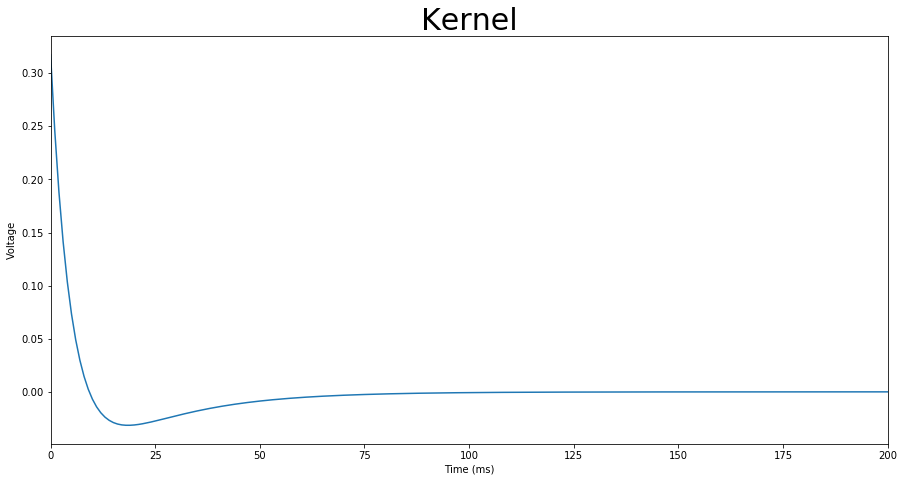

In [247]:
tau_mem = 20 #ms
tau_syn = 5 #ms
time_ij = 0 #ms

def dif_kernel(data, tau_mem, tau_syn, time_ij):
    time = np.arange(0., len(data[0]), 1.) #ms
    kernel = np.zeros(len(data[0]))
    eta = tau_mem/tau_syn
    V_norm = eta**(eta/(eta-1))/(eta-1)
    for count in range(len(data[0])):
        kernel[count] = V_norm*(-(np.exp(-(time[count]-time_ij)/tau_mem))/tau_mem+(np.exp(-(time[count]-time_ij)/tau_syn))/tau_syn)  
    return kernel

time = np.arange(0., len(data[0]), 1.) #ms
diff_kernel = dif_kernel(data, tau_mem, tau_syn, time_ij)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Kernel", fontsize=30)
plt.plot(time, diff_kernel)
plt.xlim((0,200))

(0, 200)

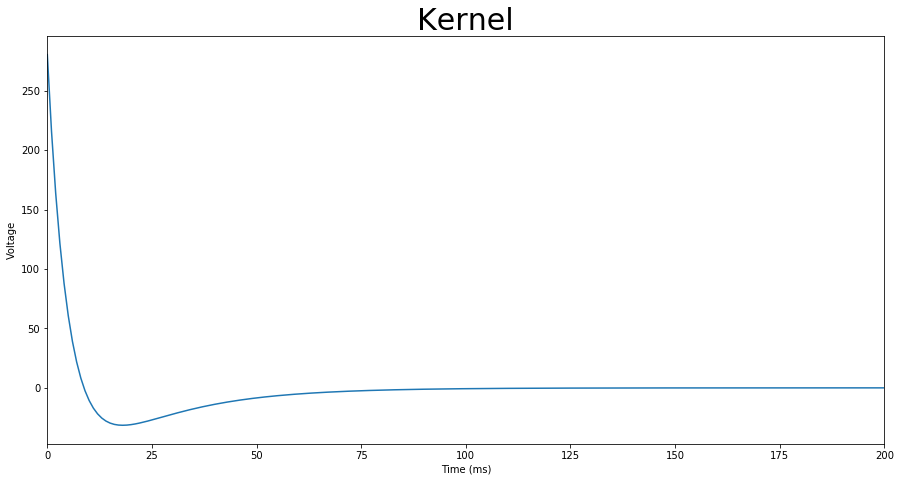

In [90]:
kernel = kernel_fn(data, tau_mem, tau_syn, time_ij)
dif_kernel = (kernel[1:] - kernel[:-1])/0.001

time = np.arange(0., 999, 1.) #ms
plt.xlabel("Time (ms)")
plt.ylabel("Voltage")
plt.title("Kernel", fontsize=30)
plt.plot(time, dif_kernel)
plt.xlim((0,200))

In [248]:
def dV0t_dt(data, diff_kernel):    #eqn 32 first part
    diff_kernel_array = np.zeros((n,len(data[0])))
    for neuron, ith_bin in zip(*np.where(data)):
        diff_kernel_array[neuron, ith_bin:] += np.multiply(diff_kernel, omega[neuron])[:len(diff_kernel)-ith_bin]
    return diff_kernel_array.sum(axis=0)

In [249]:
def t_derivative(data, sum_diff_kernel, tot_input, C, spike_time, x):    #eqn 32
    return sum_diff_kernel[spike_time[x]]/C[x] + tot_input[spike_time[x]]*sum(np.exp(-(spike_time[x]-spike_time[j])/tau_mem) for j in range(x))/(tau_mem*C[x]**2)


In [250]:
def A_cache(n_spikes, sum_diff_kernel, tot_input, C, spike_time):
    A_cache = np.zeros(n_spikes)
    for k in range(n_spikes):
        A_cache[k] = fn_A(data, sum_diff_kernel, tot_input, A_cache, C, spike_time, k)
    return A_cache

In [251]:
def fn_A(data, sum_diff_kernel, tot_input, A, C, spike_time, k):    #eqn 23
    return 1 - sum(A[j]/t_derivative(data, sum_diff_kernel, tot_input, C, spike_time, j)*dVtx_dtsk(tot_input, C, spike_time, k, j) for j in range(k))


In [252]:
def B_cache(n_spikes, sum_diff_kernel, tot_input, dVt_dwi, C, spike_time):
    B_cache = np.zeros(n_spikes)
    for k in range(n_spikes):
        B_cache[k] = fn_B(data, sum_diff_kernel, tot_input, B_cache, C, spike_time, dVt_dwi, k)
    return B_cache

In [253]:
def fn_B(data, sum_diff_kernel, tot_input, B, C, spike_time, dVt_dwi, k):    #eqn 24
    if len(dVt_dwi) != 0:
        return -dVt_dwi[k] - sum(B[j]/t_derivative(data, sum_diff_kernel, tot_input, C, spike_time, j)*dVtx_dtsk(tot_input, C, spike_time, k, j) for j in range(k))
    else:
        return 0 - sum(B[j]/t_derivative(data, sum_diff_kernel, tot_input, C, spike_time, j)*dVtx_dtsk(tot_input, C, spike_time, k, j) for j in range(k))
    

In [254]:
def theta_grad_i(A_cache, B_cache, star):   #Eqn 27
    return -B_cache[star]/A_cache[star]

In [255]:
def theta_critical_grad(n, sum_diff_kernel, tot_input, dVt_dw, A, C, spike_time, n_spikes, star):
    grad = np.zeros(n)
    for count in range(n):
        dVt_dwi = dVt_dw[count]
        B = B_cache(n_spikes, sum_diff_kernel, tot_input, dVt_dwi, C, spike_time)
        grad[count] += theta_grad_i(A, B, star)
    return grad

In [256]:
def update_w(omega, learning_rate, desired_spikes, num_spikes, sum_diff_kernel, tot_input, dVt_dw, A, C, spike_time, n_spikes, star):
    if num_spikes > desired_spikes:
        return omega - learning_rate*theta_critical_grad(n, sum_diff_kernel, tot_input, dVt_dw, A, C, spike_time, n_spikes, star)
    elif num_spikes < desired_spikes:
        return omega + learning_rate*theta_critical_grad(n, sum_diff_kernel, tot_input, dVt_dw, A, C, spike_time, n_spikes, star)
    else:
        return omega

# Multispike Training

In [322]:
#elig = eligibility(data, V_t)
#desired_spikes = 5
#learning_rate = 0.01 #lambda
#updated_omega = synaptic_update(elig, random_omega, learning_rate, desired_spikes)
#V_t, num_spikes = calculate_Vt(data, theta, omega_coefficient, random_omega)
#omega = np.copy(random_omega)
theta_range = [0, 5]

def multispike_training(current_omega, n_cycles, fea_idx, learning_rate):
    t1 = t.perf_counter()
    cycle = 0
    seed = 0
    cur_omega_list = []
    while cycle < n_cycles:     
        trial = cycle*100
        while seed < trial+100:
            data, markers, n_fea_occur, fea_time, fea_order, features = gen_input_data(seed, T_null, n, fr, dt, n_fea, T_fea, cf_mean, marker_y, marker_height)  
            desired_spikes = n_fea_occur[fea_idx] #+ n_fea_occur[fea_idx+1]*2 + n_fea_occur[fea_idx+2]*3 + n_fea_occur[fea_idx+3]*4 + n_fea_occur[fea_idx+4]*5
            V_t, num_spikes, spike_time, sum_time_exp, plain_kernel, tot_input = calculate_Vt(data, theta, current_omega)
            print('1', num_spikes, desired_spikes)
            if num_spikes != desired_spikes:
                theta_star, tx_list = theta_critical(data, num_spikes, desired_spikes, theta_range, 0.00001, current_omega)
                C = C_tx(sum_time_exp, tx_list)
                dVt_dw = dVtx_dwi(plain_kernel, tx_list, C)
                diff_kernel = dif_kernel(data, tau_mem, tau_syn, time_ij)
                sum_diff_kernel = dV0t_dt(data, diff_kernel)
                #import pdb; pdb.set_trace()
                A = A_cache(len(tx_list), sum_diff_kernel, tot_input, C, tx_list)
                t_star = len(tx_list)-1
                current_omega = update_w(current_omega, learning_rate, desired_spikes, num_spikes, sum_diff_kernel, tot_input, dVt_dw, A, C, tx_list, len(tx_list), t_star)
                #V_t, new_num_spikes, spike_time = calculate_Vt(data, theta, current_omega)
                #print('2', new_num_spikes, desired_spikes)
            seed += 1
            print('s: '+str(seed))
            cur_omega_list.append(current_omega)
        cycle += 1
        #print('c: '+str(cycle)) #+'; current_omega = '+str(current_omega))
    print(t.perf_counter()-t1)
    return cur_omega_list
cur_omegaMulti_list = multispike_training(omega, 1, 0, 0.0001)
#np.save("cur_omegaMulti_list", cur_omegaMulti_list)

1 15 3
s: 1
1 4 2
s: 2
1 4 1
s: 3
1 2 2
s: 4
1 5 5
s: 5
1 2 2
s: 6
1 2 3
s: 7
1 3 0
s: 8
1 6 4
s: 9
1 0 0
s: 10
1 1 1
s: 11
1 1 1
s: 12
1 1 1
s: 13
1 4 5
s: 14
1 3 3
s: 15
1 3 2
s: 16
1 0 1
s: 17
1 6 2
s: 18
1 3 3
s: 19
1 1 0
s: 20
1 0 4
s: 21
1 1 0
s: 22
1 0 1
s: 23
1 6 3
s: 24
1 3 4
s: 25
1 8 3
s: 26
1 4 2
s: 27
1 1 4
s: 28
1 7 2
s: 29
1 3 2
s: 30
1 3 3
s: 31
1 3 4
s: 32
1 6 4
s: 33
1 1 1
s: 34
1 0 0
s: 35
1 2 2
s: 36
1 3 3
s: 37
1 3 2
s: 38
1 1 5
s: 39
1 7 3
s: 40
1 2 1
s: 41
1 0 1
s: 42
1 6 4
s: 43
1 0 0
s: 44
1 1 1
s: 45
1 3 3
s: 46
1 2 2
s: 47
1 0 0
s: 48
1 1 0
s: 49
1 0 1
s: 50
1 3 1
s: 51
1 1 1
s: 52
1 0 1
s: 53
1 7 3
s: 54
1 3 2
s: 55
1 0 0
s: 56
1 2 3
s: 57
1 3 0
s: 58
1 3 2
s: 59
1 1 2
s: 60
1 4 1
s: 61
1 3 2
s: 62
1 0 0
s: 63
1 0 2
s: 64
1 5 2
s: 65
1 1 1
s: 66
1 1 1
s: 67
1 2 3
s: 68
1 5 1
s: 69
1 2 2
s: 70
1 5 5
s: 71
1 1 1
s: 72
1 1 0
s: 73
1 3 3
s: 74
1 3 3
s: 75
1 1 1
s: 76
1 2 2
s: 77
1 3 3
s: 78
1 0 0
s: 79
1 2 2
s: 80
1 2 2
s: 81
1 1 1
s: 82
1 2 2
s: 83
1 2 2
s: 84


In [300]:
%debug

> <ipython-input-298-572083756145>(9)theta_critical()
      7     theta_list, spike_list = bisect(data, theta_spikes, theta_range, smallest_range, omega)
      8     theta_critical_range = optimize.root(root_fun, [theta_list[spike_list.index(theta_spikes)-1], theta_list[spike_list.index(theta_spikes)]], args=(data, omega)).x
----> 9     assert (theta_critical_range[0] - theta_critical_range[1] < 0.000000001), "Root not converged!"
     10     new_V = STS(data, theta_critical_range[0]-0.0000000000001, omega)
     11     t_star_list = new_V[1][:new_V[2].index(min(new_V[2]))+1]

ipdb> num_spikes
15
ipdb> desired_spikes
3
ipdb> omega
array([ 0.00948951,  0.01677219,  0.01643535,  0.02579509,  0.00403931])
ipdb> theta_critical_range
array([ 1.00882872,  1.00882868])
ipdb> exit


In [163]:
omega

array([ 0.00948951,  0.01677219,  0.01643535,  0.02579509,  0.00403931])

In [323]:
#with root
cur_omegaMulti_list

[array([ 0.00887795,  0.01609497,  0.01561877,  0.02484694,  0.00315762]),
 array([ 0.00765948,  0.01530837,  0.01452679,  0.02372743,  0.00218277]),
 array([ 0.00642496,  0.01413392,  0.01325238,  0.02192805,  0.00086282]),
 array([ 0.00642496,  0.01413392,  0.01325238,  0.02192805,  0.00086282]),
 array([ 0.00642496,  0.01413392,  0.01325238,  0.02192805,  0.00086282]),
 array([ 0.00642496,  0.01413392,  0.01325238,  0.02192805,  0.00086282]),
 array([ 0.00792082,  0.01571228,  0.01490689,  0.02376867,  0.00252822]),
 array([ 0.00704061,  0.01492294,  0.01403313,  0.02303478,  0.00182105]),
 array([ 0.00600133,  0.01388808,  0.01313401,  0.02176857,  0.00062316]),
 array([ 0.00600133,  0.01388808,  0.01313401,  0.02176857,  0.00062316]),
 array([ 0.00600133,  0.01388808,  0.01313401,  0.02176857,  0.00062316]),
 array([ 0.00600133,  0.01388808,  0.01313401,  0.02176857,  0.00062316]),
 array([ 0.00600133,  0.01388808,  0.01313401,  0.02176857,  0.00062316]),
 array([ 0.00682655,  0.0

In [164]:
cur_omegaMulti_list

[array([ 0.00856455,  0.01594871,  0.01556816,  0.0248585 ,  0.00313596]),
 array([ 0.00744553,  0.01463214,  0.01424407,  0.02360715,  0.00211201]),
 array([ 0.00654565,  0.01364949,  0.0132113 ,  0.02278201,  0.0013112 ]),
 array([ 0.00654565,  0.01364949,  0.0132113 ,  0.02278201,  0.0013112 ]),
 array([ 0.00654565,  0.01364949,  0.0132113 ,  0.02278201,  0.0013112 ]),
 array([ 0.00654565,  0.01364949,  0.0132113 ,  0.02278201,  0.0013112 ]),
 array([ 0.00804842,  0.01523506,  0.01487468,  0.02462373,  0.00298347]),
 array([ 0.00724953,  0.0145253 ,  0.01398649,  0.02390414,  0.002331  ]),
 array([ 0.00648205,  0.01351697,  0.01293308,  0.0224277 ,  0.00129947]),
 array([ 0.00648205,  0.01351697,  0.01293308,  0.0224277 ,  0.00129947]),
 array([ 0.00648205,  0.01351697,  0.01293308,  0.0224277 ,  0.00129947]),
 array([ 0.00648205,  0.01351697,  0.01293308,  0.0224277 ,  0.00129947]),
 array([ 0.00648205,  0.01351697,  0.01293308,  0.0224277 ,  0.00129947]),
 array([ 0.00648205,  0.0

In [195]:
cur_omegaMulti_list[99] - omega

array([-0.00435033, -0.00205976, -0.00298112,  0.00018863, -0.00055368])

In [ ]:
analyse with different i number iof inputs

In [237]:
def hi(n):
    b = []
    for a in range(n):
        if a < 8 and a > 3:
            b.append(0)
        else:
            b.append(1)
    return b
print(hi(11))
a = np.array(([1,2,3], [4,5,6]))
b = np.array(([2,3,4],))
#c = b/a**2
d = np.array([1,2,1])
#e = a*b[:,np.newaxis]
print(a[:,np.newaxis])
#print(e)
a.shape

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
[[[1 2 3]]

 [[4 5 6]]]


(2, 3)